<div align="center">
<h1 align="center"><strong>Validation on RateBeer dataset</strong></h1>
  <p align="center">
    Applied Data Analysis (CS-401)
  </p>
</div>

The goal of this notebook is to replicate the analysis done on the BeerAdvocate dataset on the RateBeer dataset. This way we can see if the same conclusion and patterns hold.


# **RateBeer** - Data Analysis

In [78]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
# Plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
# Stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
# Text
from langdetect import detect
from html import unescape
# Other
import os
from datetime import datetime
import help_functions as helpfn
import warnings

In [79]:
# Define the data folder paths for BeerAdvocate
DATA_FOLDER = '../DATA/RateBeer/'

# Define the file paths for the datasets
Beers_DATASET = DATA_FOLDER+"beers.csv"
Users_DATASET = DATA_FOLDER+"users.csv"
Reviews_DATASET = DATA_FOLDER+"reviews_RB.csv"
Breweries_DATASET = DATA_FOLDER+"breweries.csv"

# **1. Dataset Exploration & Cleaning**

The first step of the project consists in exploring the data available in the dataset as well as pre-processing them. This step consists mainly in handling the potential missing data and reformatting what needs to be reformated. The following subsections present this step for every datasets available.

## **1.1 Users**

The first dataset of interest is the one containing information about users. The dataset includes the following columns:

- `nbr_ratings`: Number of ratings made.
- `user_id`: Unique user identifier.
- `user_name`: User Name.
- `joined`:  Date of the sign up.
- `location`: Location of the User.


In [80]:
# Read the datasets into Pandas DataFrames
users = pd.read_csv(Users_DATASET)
display(users)

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
...,...,...,...,...,...
70169,1,134893,stamfordbus,1.315217e+09,England
70170,1,327816,fobia405,1.406282e+09,Belgium
70171,1,183139,junkin,1.339841e+09,NaN
70172,3,82020,klesidra,1.222250e+09,Slovenia


The dataset is composed of 70174 users, which is less than BeerAdvocate (153'704). We can see that some data are missing and that some users did not gave any review. To address these issues our pre-processing involves the following steps:

- **Filtering Users with 0 number of reviews**: Deleting users with 0 reviews, as they are not characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the `nbr_reviews`, `user_id`, `user_name` and `location` columns.

- **Check for Duplicated Users**: Check if there are multiple user with the same id.

- **Formatting the date**: Reformat the date in the column `joined` in UTC format.

In [8]:
# Create a deep copy of the 'users' dataframe
users_filt = users.copy(deep=True)
users_filt.rename(columns={'nbr_ratings': 'nbr_reviews'}, inplace=True)
# Check for duplicates based on user name and user ID
dupli_name = np.sum(users_filt.duplicated(subset=['user_name']))
dupli_ID = np.sum(users_filt.duplicated(subset=['user_id']))

# Remove users with 0 reviews and NaN as the number of reviews
users_filt = users_filt[users_filt['nbr_reviews'] >= 1]
users_filt = users_filt[users_filt['nbr_reviews'].notna()]

# Remove rows with NaN in 'user_id', 'user_name', and 'location'
users_filt = users_filt[users_filt['user_id'].notna()]
users_filt = users_filt[users_filt['user_name'].notna()]
users_filt = users_filt[users_filt['location'].notna()]

# Convert 'joined' column to datetime type
users_filt['joined'] = users_filt['joined'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)

# Rename the 'location' column to 'user_location'
users_filt.rename(columns={'location': 'user_location'}, inplace=True)

# Display the resulting dataframe
display(users_filt)

# Display the number of duplicate user names and user IDs
print(f'Number of duplicate user names = {dupli_name}')
print(f'Number of duplicate user IDs = {dupli_ID}')

# Display the number of NaN values in each category
print('Number of NaN by category:')
print(np.sum(users_filt.isna()))


,nbr_reviews,user_id,user_name,joined,user_location
0,1890,175852,Manslow,2012-05-20 10:00:00,Poland
1,89,442761,MAGICuenca91,2017-01-10 11:00:00,Spain
2,169,288889,Sibarh,2013-11-16 11:00:00,Poland
3,3371,250510,fombe89,2013-03-22 11:00:00,Spain
4,13043,122778,kevnic2008,2011-02-02 11:00:00,Germany
...,...,...,...,...,...
70167,1,181614,HaraldS,2012-06-16 10:00:00,Norway
70169,1,134893,stamfordbus,2011-09-05 10:00:00,England
70170,1,327816,fobia405,2014-07-25 10:00:00,Belgium
70172,3,82020,klesidra,2008-09-24 10:00:00,Slovenia


Number of duplicate user names = 0
Number of duplicate user IDs = 54
Number of NaN by category:
nbr_reviews      0
user_id          0
user_name        0
joined           0
user_location    0
dtype: int64


After pre-processing, a total of 50'592 users with complete information are kept.

## **1.2 Breweries**

Next, we conduct the pre-processing of the dataset containing information about breweries. The dataset comprises the following columns:

- `id`: Brewery identifier.
- `location`: Location of the brewery.
- `name`: Name of the brewery.
- `nbr_beers`: Number of beers produced.


In [10]:
# Read the datasets into Pandas DataFrames
breweries = pd.read_csv(Breweries_DATASET)
display(breweries)

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3
...,...,...,...,...
24184,28180,Albania,Shoqeria Picana,1
24185,1107,Albania,Stefani & Co,11
24186,9355,Albania,Hotel Martini,1
24187,9928,Albania,Rozafa Brewery,1


The dataset is composed of 24'189 breweries, which is more than on BeerAdvocate (16'758). We can directly see that some breweries have 0 beers and are therefore not relevant for our analysis. There might be some missing values as well, thus we decided to perform the following pre_processing steps:

- **Filtering Breweries with 0 number of beers**: Deleting breweries with 0 beers, as they are not characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the `nbr_beers`.

- **Removing Duplicates**: Dropping duplicate entries based on the `name` column.

In [11]:
# Create a deep copy of the 'breweries' dataframe
breweries_filt = breweries.copy(deep=True)

# Check for duplicates based on ID
dupli_ID = np.sum(breweries_filt.duplicated(subset=['id']))

# Remove breweries with 0 beers and NaN values
breweries_filt = breweries_filt[breweries_filt['nbr_beers'] >= 1]
breweries_filt = breweries_filt[breweries_filt.notna()]

# Remove duplicate entries based on brewery name
breweries_filt = breweries_filt.drop_duplicates(subset='name')

# Check for duplicates based on name
dupli_name = np.sum(breweries_filt.duplicated(subset=['name']))

# Rename columns for consistency
breweries_filt.rename(columns={'name': 'brewery_name', 'id': 'brewery_id', 'location': 'brewery_location'}, inplace=True)

# Display the resulting dataframe
display(breweries_filt)

# Display the number of duplicate names and IDs
print(f'Number of duplicate names = {dupli_name}')
print(f'Number of duplicate IDs = {dupli_ID}')

# Display the number of NaN values in each category
print('Number of NaN by category:')
print(np.sum(breweries_filt.isna()))


,brewery_id,brewery_location,brewery_name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3
...,...,...,...,...
24184,28180,Albania,Shoqeria Picana,1
24185,1107,Albania,Stefani & Co,11
24186,9355,Albania,Hotel Martini,1
24187,9928,Albania,Rozafa Brewery,1


Number of duplicate names = 0
Number of duplicate IDs = 0
Number of NaN by category:
brewery_id          0
brewery_location    0
brewery_name        0
nbr_beers           0
dtype: int64


After pre-processing, 24'102 breweries are remaining. 

## **1.3 Reviews**

We now delve into the BeerAdvocate Reviews dataset, focusing on reviews of various beers. The dataset contains the following columns:

- `beer_name`: Name of the beer.
- `beer_id`: Identifier for the beer.
- `brewery_name`: Name of the brewery producing the beer.
- `brewery_id`: Identifier for the brewery.
- `style`: Beer style.
- `abv`: Alcohol by volume.
- `date`: Timestamp of the review.
- `user_name`: Username of the reviewer.
- `user_id`: Identifier for the user.
- `appearance`: Rating for the beer's appearance.
- `aroma`: Rating for the beer's aroma.
- `palate`: Rating for the beer's palate.
- `taste`: Rating for the beer's taste.
- `overall`: Overall rating.
- `rating`: Overall user rating.
- `text`: Review text.

Since the .txt file containing the reviews is huge, we first converted it into smaller files that we then regrouped in a .csv file. The code in `split_reviews.py` was used for this purpose. We are aware that this is not the best practice when dealing with large files but since we already did that for Milestone P2, we decided to stick with it and keep it in mind for our future projects.

In [14]:
# Read the Reviews dataset into a pandas DataFrame.
reviews_BA = pd.read_csv(Reviews_DATASET)
display(reviews_BA)

C:\Users\begue\AppData\Local\Temp\ipykernel_19184\2230147237.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_BA = pd.read_csv(Reviews_DATASET)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Teme Valley Talbot Blond,73245,Teme Valley,3086,Golden Ale/Blond Ale,4.4,1437127200,AshtonMcCobb,124423,4,6,4,6,13,3.3,"On cask at the Firefly, Worcester. Appearance..."
1,Teme Valley Talbot Blond,73245,Teme Valley,3086,Golden Ale/Blond Ale,4.4,1347184800,Fin,32589,4,7,3,7,13,3.4,"Cask, gravity at the Beer Tent, Bromyard Fol..."
2,Teme Valley Talbot Blond,73245,Teme Valley,3086,Golden Ale/Blond Ale,4.4,1339322400,imdownthepub,6843,4,6,3,7,12,3.2,"Cask conditioned at The Wellington, Birmingha..."
3,Teme Valley Talbot Blond,73245,Teme Valley,3086,Golden Ale/Blond Ale,4.4,1314525600,FatPhil,51287,3,5,3,5,11,2.7,"Cask (GBBF2011, Thursday)Mid gold, ring head...."
4,Teme Valley Talbot Blond,73245,Teme Valley,3086,Golden Ale/Blond Ale,4.4,1313402400,Theis,38018,3,5,2,5,12,2.7,Cask at GBBF 2011 - Tuesday. Clear golden - w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7122069,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,Altbier,4.5,1087898400,IPFreely,7650,3,5,3,5,11,2.7,"Amber color, light tan head. Mild caramel, a ..."
7122070,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,Altbier,4.5,1076929200,mds,5899,3,6,3,6,12,3.0,Draught. Interesting aroma of roasted malt. T...
7122071,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,Altbier,4.5,1076324400,estoppel,3468,3,6,3,6,13,3.1,"Dark golden body, some Saaz or noble hops wit..."
7122072,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,Altbier,4.5,1035716400,austinpowers,3677,3,7,3,7,14,3.4,"Trainwreck. Ahh, this must be a melange of f..."


Our pre-processing begins with the following initial steps:

- **Converting Timestamps to Datetime**: We start by converting the 'date' column, which contains timestamps, into the datetime format. This conversion enables us to perform time-based analyses more effectively.

- **Handling Missing Values**: We address missing values in the dataset by dropping rows with NaN values. This ensures that our analysis is based on complete and reliable data.

- **Removing Unnecessary Column**: The 'abv' column, representing the alcohol by volume, is not useful for our specific analysis. Consequently, we opt to drop this column to streamline our dataset.

- **Removing White Space before and after Stings**: Some strings columns like `user_name` begin with a white space, which is a problem for merging. Consequently we need to remove them.

In [16]:
# Create a deep copy of the reviews_BA DataFrame to avoid modifying the original DataFrame.
reviews_filt = reviews_BA.copy(deep=True)

# Convert the 'date' column to a datetime format.
# If the 'date' value is not NaN, apply the conversion using utcfromtimestamp.
# If the 'date' value is NaN, leave it unchanged.
reviews_filt['date'] = reviews_filt['date'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)

# Drop rows where the 'text' column has NaN values.
reviews_filt = reviews_filt[reviews_filt['text'].notna()]

# Drop the 'abv' column from the reviews_filt DataFrame.
reviews_filt = reviews_filt.drop(['abv'], axis=1)

# Remove leading and trailing whitespaces (if they exist) from the following columns: 
# user_id, user_name, beer_name, brewery_name, style, and text.
#reviews_filt.user_id = reviews_filt.user_id.apply(lambda x: x.strip())
reviews_filt.user_name = reviews_filt.user_name.astype(str).apply(lambda x: x.strip())
reviews_filt.beer_name = reviews_filt.beer_name.apply(lambda x: x.strip())
reviews_filt.brewery_name = reviews_filt.brewery_name.apply(lambda x: x.strip())
reviews_filt.style = reviews_filt.style.apply(lambda x: x.strip())
reviews_filt.text = reviews_filt.text.apply(lambda x: x.strip())

# Display the updated reviews_filt DataFrame.
display(reviews_filt)

# Print the number of NaN values for each column in the reviews_filt DataFrame.
print('Number of NaN by category:')
print(np.sum(reviews_filt.isna()))


,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2015-07-17 10:00:00,AshtonMcCobb,124423,4,6,4,6,13,3.3,"On cask at the Firefly, Worcester. Appearance ..."
1,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2012-09-09 10:00:00,Fin,32589,4,7,3,7,13,3.4,"Cask, gravity at the Beer Tent, Bromyard Folk ..."
2,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2012-06-10 10:00:00,imdownthepub,6843,4,6,3,7,12,3.2,"Cask conditioned at The Wellington, Birmingham..."
3,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2011-08-28 10:00:00,FatPhil,51287,3,5,3,5,11,2.7,"Cask (GBBF2011, Thursday)Mid gold, ring head. ..."
4,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2011-08-15 10:00:00,Theis,38018,3,5,2,5,12,2.7,Cask at GBBF 2011 - Tuesday. Clear golden - wh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7122069,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2004-06-22 10:00:00,IPFreely,7650,3,5,3,5,11,2.7,"Amber color, light tan head. Mild caramel, a b..."
7122070,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2004-02-16 11:00:00,mds,5899,3,6,3,6,12,3.0,Draught. Interesting aroma of roasted malt. Tr...
7122071,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2004-02-09 11:00:00,estoppel,3468,3,6,3,6,13,3.1,"Dark golden body, some Saaz or noble hops with..."
7122072,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2002-10-27 11:00:00,austinpowers,3677,3,7,3,7,14,3.4,"Trainwreck. Ahh, this must be a melange of fl..."


Number of NaN by category:
beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            0
dtype: int64


We now aim to visualize the distribution of the length of the reviews to:

- **Get insight into review length variation**: Visualizing the distribution allows us to understand the range and variability in review lengths. Some reviews may be succinct, while others may be more detailed.

- **Assess data quality**: Analyzing review lengths can also serve as a quality check. Unusually short or long reviews may warrant further investigation to ensure data integrity.


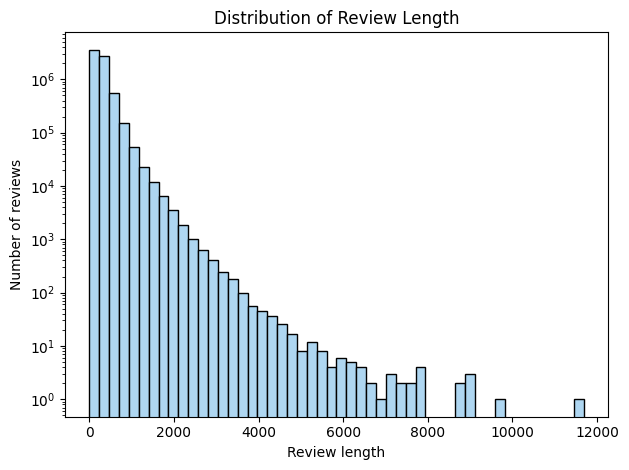

In [17]:
# Define pastel colors
pastel_blue = '#AED6F1'
pastel_red = '#F1948A'
pastel_green = '#ABEBC6'

# Create a histogram of the review lengths using the 'text' column from the reviews_filt DataFrame.
plt.hist(reviews_filt['text'].str.len(), bins=50, log=True, color=pastel_blue, edgecolor='black')

# Set x-axis and y-axis labels and the title.
plt.xlabel('Review length')
plt.ylabel('Number of reviews')
plt.title('Distribution of Review Length')

plt.tight_layout()
plt.show()

The website recommends generating **reviews of at least 150 characters**.

However, upon inspection, it is clear that **not all reviews meet this criterion**. Therefore, in the subsequent steps, we will exclude reviews that shorter than the specified length to retain only pertinent ones.

The statistical overview of review lengths is presented in the following section. 

**The median length is observed to be 580 characters**. Nevertheless, the distribution exhibits skewness, with a limited number of reviews surpassing 5000 characters. 

It is advisable to monitor exceptionally lengthy reviews, as they may potentially be fake.

In [18]:
# Display descriptive statistics of the review lengths.
reviews_filt['text'].str.len().describe()

count    7.121626e+06
mean     2.848247e+02
std      1.983675e+02
min      1.000000e+00
25%      1.660000e+02
50%      2.340000e+02
75%      3.420000e+02
max      1.168200e+04
Name: text, dtype: float64

In [19]:
# Set the minimum number of characters for reviews
MIN_NUMBER_OF_CHARACTER = 150

# Filter out reviews with fewer than 150 characters
reviews_filt = reviews_filt[reviews_filt['text'].str.len() > MIN_NUMBER_OF_CHARACTER]

We then undertook further pre-processing, focusing on the textual representation of reviews. We followed the following steps:

- **Management of special characters**: After examining the modified and translated dataset, we observed the presence of some special characters such as "\&quot;" and "\x92" in some reviews. To solve this problem, we used the html.unescape function to convert the HTML entities and then removed the non-ASCII characters by encoding them in ASCII and decoding them again.

- **Filtering short reviews**: As a final step, we filtered out reviews with less than 150 characters. This step aimed to exclude shorter reviews from our dataset, focusing on more substantial texts.

In [21]:
# Apply the 'unescape' function to decode HTML entities in the 'text' column
reviews_filt['text'] = reviews_filt['text'].apply(unescape)

# Remove non-ASCII characters by encoding to ASCII and decoding back
reviews_filt['text'] = reviews_filt['text'].apply(lambda x: x.encode('ascii', 'ignore').decode())

# Filter out reviews with fewer than 150 characters
reviews_filt = reviews_filt[reviews_filt['text'].str.len() > MIN_NUMBER_OF_CHARACTER]

C:\Users\begue\AppData\Local\Temp\ipykernel_19184\3176614385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_filt['text'] = reviews_filt['text'].apply(unescape)
C:\Users\begue\AppData\Local\Temp\ipykernel_19184\3176614385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_filt['text'] = reviews_filt['text'].apply(lambda x: x.encode('ascii', 'ignore').decode())


In [81]:
display(reviews_filt)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2015,AshtonMcCobb,124423,4,6,4,6,13,3.3,"On cask at the Firefly, Worcester. Appearance ..."
1,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2012,Fin,32589,4,7,3,7,13,3.4,"Cask, gravity at the Beer Tent, Bromyard Folk ..."
2,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2012,imdownthepub,6843,4,6,3,7,12,3.2,"Cask conditioned at The Wellington, Birmingham..."
3,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2011,FatPhil,51287,3,5,3,5,11,2.7,"Cask (GBBF2011, Thursday)Mid gold, ring head. ..."
5,Teme Valley Talbot Blond,73245,Teme Valley,3086,<pandas.io.formats.style.Styler object at 0x00...,2011,joergen,14280,3,6,3,6,11,2.9,Cask at GBBF 2011.Clear golden coloured with a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7122065,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2005,PuckLSHS,20518,3,6,3,5,10,2.7,Amber color with light hoppy taste. I was a ...
7122066,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2009,rudolf,9118,3,6,3,7,14,3.3,"Re-rate Nov 09.Amber body, white head with nic..."
7122068,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2004,DougShoemaker,2966,3,7,3,6,13,3.2,"Candied malt, apple pie and chocolate aromas, ..."
7122069,Pearl Street Trainwreck,11142,Pearl Street Grill & Brewery &#40;NY&#41;,2056,<pandas.io.formats.style.Styler object at 0x00...,2004,IPFreely,7650,3,5,3,5,11,2.7,"Amber color, light tan head. Mild caramel, a b..."


We now have a total of 5,718,324 reviews. 

**With the datasets prepared, we can start our preliminary analysis.**

# **2 Preliminary Analysis**

The website provides data since 2000. However, it's important to note that in the initial stages of the website, only a small fraction of the population had internet access. 

Therefore we conduct some **analysis of the evolution of both the number of reviews and the number of breweries** reviewed over the years.


## **2.1 Temporal Evolution of #breweries and #reviews**

In [23]:
# Change date format to keep only the year
reviews_filt['date'] = reviews_filt['date'].apply(lambda x: x.year)

# Create dataframe that keeps for each review only the brewery id and the date
temp_df = reviews_filt[['brewery_id','date']].copy(deep=True)

# Group by year to extract the total number of reviews by year and the total of breweries by year
temporal_df = temp_df.groupby('date').agg({'brewery_id': ['count', 'nunique']}).reset_index()

# Rename the columns for clarity
temporal_df.columns = ['date', 'tot_nbr_reviews_by_year', 'tot_nbr_brew_by_year']

# Add column showing the ratio between nb of reviews and breweries by year
temporal_df['rev_by_brew'] = temporal_df.apply(lambda row: row.tot_nbr_reviews_by_year/row.tot_nbr_brew_by_year, axis = 1)

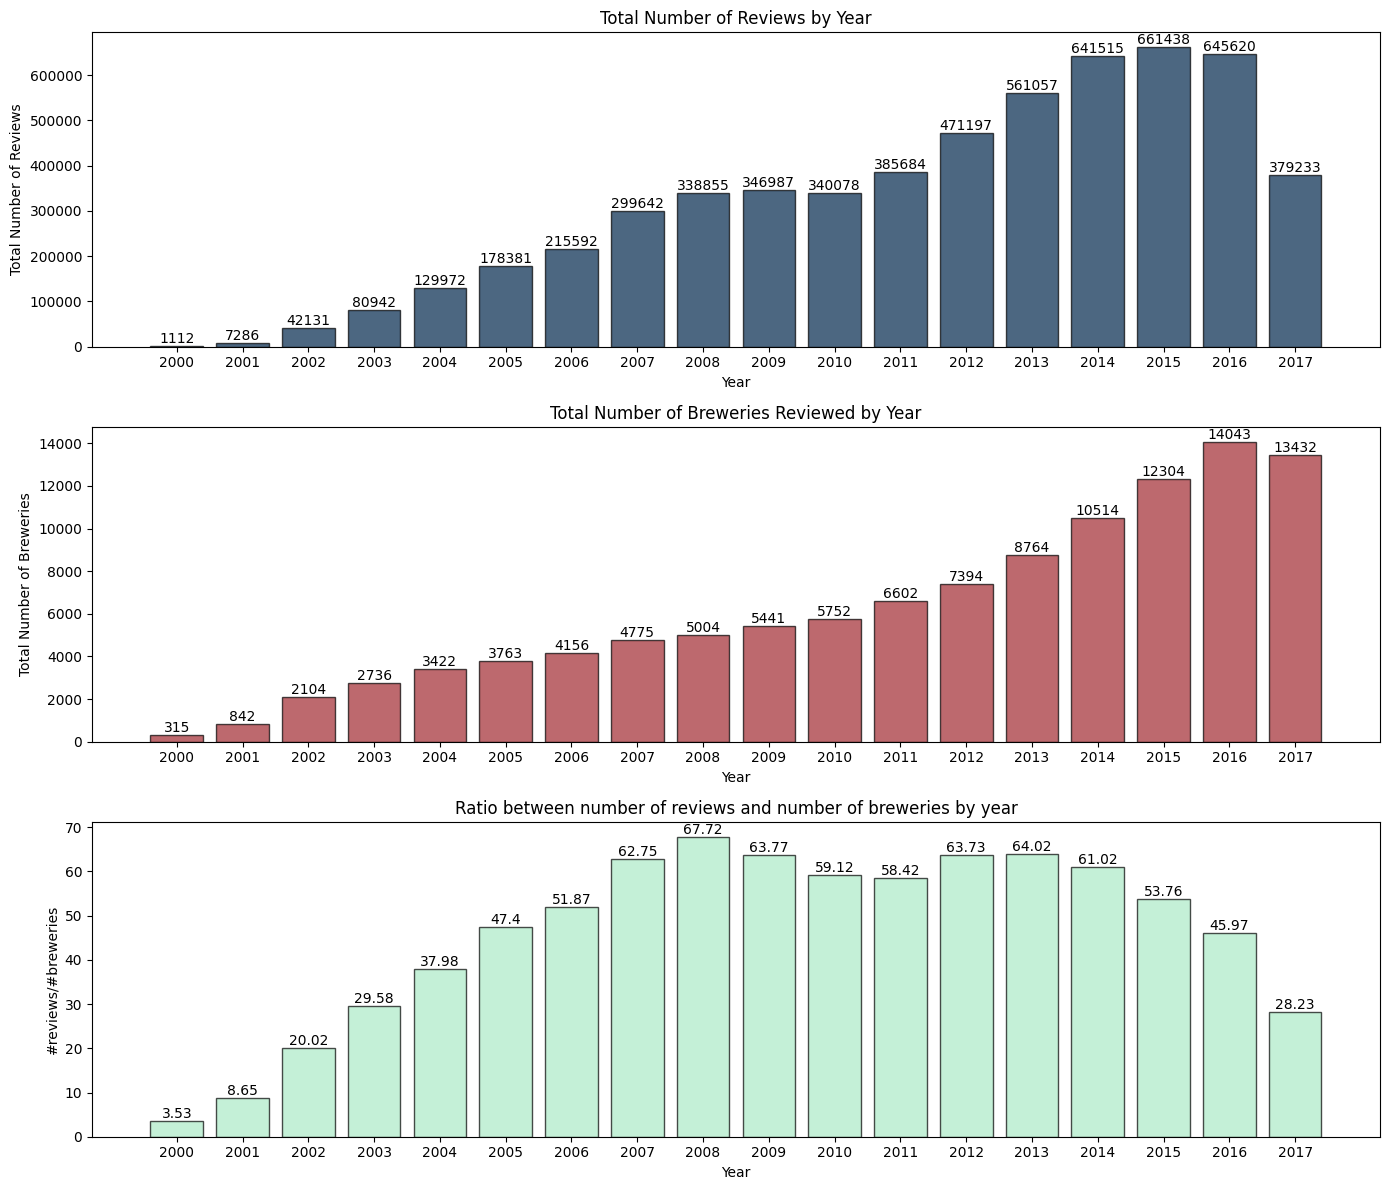

In [88]:
# Sort the DataFrame by 'date' if it's not sorted already
df = temporal_df.sort_values(by='date')

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Bar plot for total number of reviews by year
bars1 = ax1.bar(df['date'], df['tot_nbr_reviews_by_year'], color=pastel_blue, alpha=0.7, edgecolor='black')
ax1.set_title('Total Number of Reviews by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Number of Reviews')
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
ax1.set_xticks(df['date'].astype(int))
# Bar plot for total number of breweries by year
bars2 = ax2.bar(df['date'], df['tot_nbr_brew_by_year'], color=pastel_red, alpha=0.7, edgecolor='black')
ax2.set_title('Total Number of Breweries Reviewed by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Number of Breweries')
ax2.set_xticks(df['date'].astype(int))
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.xticks(df['date'].astype(int))
# Bar plot for ratio
bars3 = ax3.bar(df['date'], df['rev_by_brew'], color=pastel_green, alpha=0.7, edgecolor='black')
ax3.set_title('Ratio between number of reviews and number of breweries by year')
ax3.set_xlabel('Year')
ax3.set_ylabel('#reviews/#breweries')
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax3.set_xticks(df['date'].astype(int))
# Adjust layout
plt.tight_layout()
plt.show()

The plots above reveal a **minimal number of breweries and reviews before 2002.**

Therefore, we decided to retain data only **from 2002 to 2017**. 

Moreover, it is evident that while **the number of breweries reviewed consistently increased over the years**, **the number of reviews peaked in 2011 and subsequently declined**. This peak aligns with the apogee of blogs on the internet in 2011, providing a potential explanation for the rise in review numbers during that period.

In [25]:
# Filter out data before 2002
reviews_filt = reviews_filt[reviews_filt['date']>=2002]

## **2.2 Metrics Definition**
In our analysis, we aim to introduce **two key metrics** to quantitatively assess the characteristics of breweries: 
- **Size Metrics** 
- **Popularity Metrics**

The following cells present and compute these metrics. Given the absence of data regarding brewery revenue or the quantity of liters produced, we have chosen to rely on variables available in the dataset to formulate these metrics.

\begin{equation}
\begin{aligned}
    \\
    &\text{Size Metrics} = \alpha \log (N_r) + \beta \log (N_b) + \gamma \log (N_t) \\
    \\
    &\text{Popularity Metrics} = \dfrac{\log (N_r)}{N_b} \\
\end{aligned}
\end{equation}

With:
- $N_r =$ number of reviews received during the year
- $N_b =$ number of different beers that recieved reviews
- $N_t =$ number of different types (style) of beers that recieved reviews


The coefficients $\alpha, \beta, \gamma$ are manually set to 5, 2, and 1, respectively. This way, we put more wheight on the number of reviews, because we expect a bigger brewery to receive more reviews than a smaller one. The metrics are calculated for each brewery annually. 

For each year, the result for each brewery is normalized by dividing it by the maximum value of the year. This normalization process yields a value between 0 and 1 for each brewery, with the largest brewery of the year assigned a size index of 1.

Finally, to assess the size and popularity globally, we define the "macro" metrics as the mean of the metrics over the years. This will allow for general analysis over the entire dataset.

In [26]:
# Create dataframe with all variables needed for metrics computation

# Extract brewery_id, style, beer_id and date  columns from reviews_filt
review_brew = reviews_filt[['brewery_id', 'style', 'beer_id', 'date', 'rating']].copy(deep=True)

# Add review length to dataset for future analysis
review_brew['len_text'] = reviews_filt['text'].apply(lambda x: len(x))

# Group by brewery ID and Year of review
brew_by_year = review_brew.groupby(['brewery_id','date']).agg({
                    'style': ['count','nunique'],
                    'beer_id': 'nunique',
                    'rating': 'mean',
                    'len_text': 'mean'}).reset_index()

# Rename the columns for clarity
brew_by_year.columns = ['brewery_id','date', 'nbr_reviews', 'nbr_styles','nbr_beers','avg_rating','mean_len_text']

# Drop if only 1 review
brew_by_year = brew_by_year[brew_by_year['nbr_reviews']>=2]

display(brew_by_year.sort_values(['date','brewery_id']))


,brewery_id,date,nbr_reviews,nbr_styles,nbr_beers,avg_rating,mean_len_text
0,1,2002,155,1,12,2.952903,288.767742
16,2,2002,8,1,6,3.562500,286.500000
32,3,2002,13,1,4,3.638462,297.153846
48,4,2002,96,1,8,3.560417,310.447917
64,5,2002,13,1,8,3.438462,360.923077
...,...,...,...,...,...,...,...
110184,32195,2017,4,1,4,2.450000,266.500000
110186,32199,2017,2,1,1,1.600000,248.500000
110187,32200,2017,2,1,2,3.400000,634.500000
110199,32221,2017,2,1,2,2.400000,376.500000


In [27]:
#### Metrics computation ####
df_metrics = brew_by_year.copy(deep=True)

# Compute size metrics
df_metrics['size_metrics'] = df_metrics.apply(lambda row: 5*np.log(row.nbr_reviews) + np.log(row.nbr_styles) + 2*np.log(row.nbr_beers), axis = 1)
# Apply the normalization within each year
df_metrics['size_metrics'] = df_metrics.groupby('date')['size_metrics'].transform(helpfn.normalize_column)

# Compute popularity metrics
df_metrics['popularity_metrics'] = df_metrics.apply(lambda row: np.log(row.nbr_reviews)/row.nbr_beers, axis = 1)
# Apply the normalization within each year
df_metrics['popularity_metrics'] = df_metrics.groupby('date')['popularity_metrics'].transform(helpfn.normalize_column)

display(df_metrics)


,brewery_id,date,nbr_reviews,nbr_styles,nbr_beers,avg_rating,mean_len_text,size_metrics,popularity_metrics
0,1,2002,155,1,12,2.952903,288.767742,0.686790,0.114720
1,1,2003,200,1,12,2.819500,307.180000,0.700441,0.123210
2,1,2004,265,1,15,2.815094,271.516981,0.712562,0.092825
3,1,2005,367,1,23,2.720436,316.190736,0.749402,0.060036
4,1,2006,515,1,18,2.895728,329.900971,0.760060,0.079860
...,...,...,...,...,...,...,...,...,...
110184,32195,2017,4,1,4,2.450000,266.500000,0.195538,0.092144
110186,32199,2017,2,1,1,1.600000,248.500000,0.069835,0.184289
110187,32200,2017,2,1,2,3.400000,634.500000,0.097769,0.092144
110199,32221,2017,2,1,2,2.400000,376.500000,0.097769,0.092144


We now have a dataframe containing the computed size and popularity metrics for each brewery on an annual basis. Then, we create a second dataframe for the macro analysis.

In [28]:
# Take the mean of the metrics over the years
# Group by brewery ID and compute mean of column needed
df_metrics_macro = df_metrics.groupby('brewery_id').agg({
                    'size_metrics': 'mean',
                    'popularity_metrics': 'mean',
                    'avg_rating': 'mean',
                    'mean_len_text': 'mean'}).reset_index()
# Rename the columns for clarity
df_metrics_macro.columns = ['brewery_id','size_metrics_macro', 'popularity_metrics_macro', 'avg_rating_macro','avg_len_text_macro']
# Add brewery name
df_metrics_macro = pd.merge(df_metrics_macro,breweries_filt[['brewery_id','brewery_name']],on=['brewery_id'], how='inner')

display(df_metrics_macro)

,brewery_id,size_metrics_macro,popularity_metrics_macro,avg_rating_macro,avg_len_text_macro,brewery_name
0,1,0.768481,0.060332,3.000945,315.480287,Abita Brewing Company
1,2,0.396573,0.074740,3.337104,308.563229,Peoples Pint
2,3,0.689298,0.066627,3.288550,299.851725,Adnams
3,4,0.734781,0.094215,3.531320,348.357384,Alaskan Brewing Company
4,5,0.354811,0.080489,2.849496,321.872436,Appleton Brewing/Adler Brau
...,...,...,...,...,...,...
19047,32195,0.195538,0.092144,2.450000,266.500000,Bees Knees Brewpub
19048,32199,0.069835,0.184289,1.600000,248.500000,MVF LLC
19049,32200,0.097769,0.092144,3.400000,634.500000,Erste Wolfgangseer Braugesellschaft mbH
19050,32221,0.097769,0.092144,2.400000,376.500000,Optium Craft Brewery (OC Brewery)


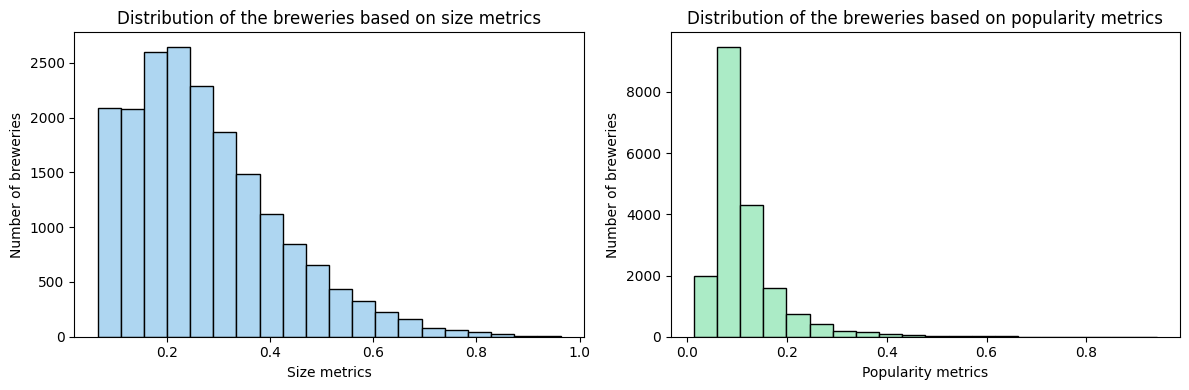

In [29]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram for 'size metrics'
axs[0].hist(df_metrics_macro['size_metrics_macro'], bins=20,color=pastel_blue, edgecolor='black')
axs[0].set_title('Distribution of the breweries based on size metrics')
axs[0].set_xlabel('Size metrics')
axs[0].set_ylabel('Number of breweries')

# Plot histogram for 'popularity metrics'
axs[1].hist(df_metrics_macro['popularity_metrics_macro'], bins=20, color=pastel_green, edgecolor='black')
axs[1].set_title('Distribution of the breweries based on popularity metrics')
axs[1].set_xlabel('Popularity metrics')
axs[1].set_ylabel('Number of breweries')

# Adjust layout
plt.tight_layout()

plt.show()

### **2.2.1 Evolution of the Size Metrics over the Year**

Let's take a look at how brewery size distribution has changed over the years. 

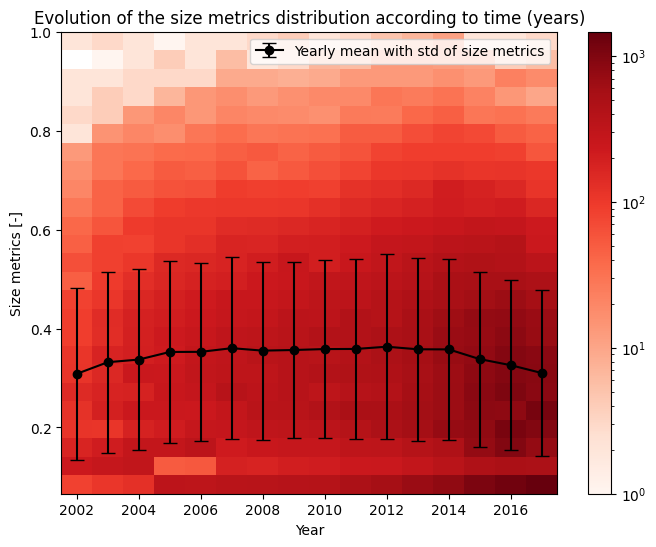

In [31]:
# Compute mean and std for plot
mean_size_year = df_metrics.groupby('date')['size_metrics'].mean()
std_size_year = df_metrics.groupby('date')['size_metrics'].std()

# Histogram of the brewery size metrics definition
years = df_metrics['date'].drop_duplicates()
plt.figure(figsize=(8, 6))
h,_,_,sc=plt.hist2d(df_metrics.date, df_metrics.size_metrics, norm=LogNorm(), bins=[np.linspace(2001.5, 2017.5, 17),25], cmap='Reds')
plt.errorbar(years, mean_size_year, yerr=std_size_year, fmt='o-', color='black', ecolor='black',label='Yearly mean with std of size metrics', capsize=5, alpha=1.0)

# Plot settings
plt.colorbar(sc)
plt.ylabel('Size metrics [-]')
plt.xlabel('Year')
plt.legend()
plt.title('Evolution of the size metrics distribution according to time (years)')
plt.show()

The distribution of brewery sizes has mainteined a relatively stable pattern throughout over the years. Nevertheless, like in the case of BeerAdvocate, starting around 2014, there has been a notable increase in the proportion of small breweries. This growth can be partly explained by the strong interest in breweries and the creation of craft beers observed between 2015 and 2020. This trend is reflected in Google searches for terms such as "brewery," which exhibited significant growth during this period, aligning with the outcomes derived from our size metric.

![Brewery Google query time evolution](images/google_search_brewery.png)

### **2.2.2 Small, medium, big breweries**

To facilitate the comparison of brewery sizes,, we define three categories:

- `small` : Size metrics between 0 and 0.3
- `medium` : Size metrics between 0.3 and 0.7
- `big` : Size metrics between 0.7 and 1.0 

This categorization allows for a meaningful comparison between the defined groups.

In [32]:
df_metrics_macro['size_category'] = df_metrics_macro['size_metrics_macro'].apply(helpfn.categorize_size)
df_metrics['size_category'] = df_metrics['size_metrics'].apply(helpfn.categorize_size)

display(df_metrics_macro)


,brewery_id,size_metrics_macro,popularity_metrics_macro,avg_rating_macro,avg_len_text_macro,brewery_name,size_category
0,1,0.768481,0.060332,3.000945,315.480287,Abita Brewing Company,big
1,2,0.396573,0.074740,3.337104,308.563229,Peoples Pint,medium
2,3,0.689298,0.066627,3.288550,299.851725,Adnams,medium
3,4,0.734781,0.094215,3.531320,348.357384,Alaskan Brewing Company,big
4,5,0.354811,0.080489,2.849496,321.872436,Appleton Brewing/Adler Brau,medium
...,...,...,...,...,...,...,...
19047,32195,0.195538,0.092144,2.450000,266.500000,Bees Knees Brewpub,small
19048,32199,0.069835,0.184289,1.600000,248.500000,MVF LLC,small
19049,32200,0.097769,0.092144,3.400000,634.500000,Erste Wolfgangseer Braugesellschaft mbH,small
19050,32221,0.097769,0.092144,2.400000,376.500000,Optium Craft Brewery (OC Brewery),small


Let's see how the breweries are divided into the size categories.

In [33]:
# Compute the percentage of breweries by size categories
perc_small_breweries = (df_metrics_macro['size_category']=='small').sum() / df_metrics_macro.shape[0] * 100
perc_medium_breweries = (df_metrics_macro['size_category']=='medium').sum() / df_metrics_macro.shape[0] * 100
perc_big_breweries = (df_metrics_macro['size_category']=='big').sum() / df_metrics_macro.shape[0] *100

print(f"Percentage of small breweries: {perc_small_breweries:.2f}",'%')
print(f"Percentage of medium breweries: {perc_medium_breweries:.2f}",'%')
print(f"Percentage of big breweries: {perc_big_breweries:.2f}",'%')

Percentage of small breweries: 63.87 %
Percentage of medium breweries: 35.04 %
Percentage of big breweries: 1.09 %


As expected, **the vast majority of breweries are small and only a minority are big breweries.**

## **2.3 Geographical Investigation**

The goal of this section is to delve into the geographical distribution of both breweries and reviewers within the dataset. Our ultimate goal is to compute the distances between breweries and their respective reviewers. This analysis will reveal whether certain category of breweries attract predominantly local reviewers or have a more globally dispersed audience.

### **2.3.1 Spatial Distribution of Breweries**

We initiate our analysis by examining the geographical distribution of breweries in the dataset. To achieve this, we integrate the dataset with a map sourced from [Geopandas](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/).

Ensuring alignment between the country names used in the map and those in the brewery dataset is crucial. To address this, we calculate the Hamming distance between them and substitute the brewery location with the closest match. In instances where no match is found, we opt to eliminate the corresponding brewery. This scenario applies to 26 breweries out of over 14,000, which is deemed acceptable for this level of analysis. It's worth noting that some removed breweries had HTTP links as their location, explaining the lack of match with the map.

For breweries located in the USA, the dataset includes information about the specific state. Consequently, we extend the same process to the states in the United States of America. To facilitate this, we introduce a new column, 'state,' in the dataframe. This allows us to split the location of US breweries into 'country' and 'state.' 

The geodataframe for the USA can be accessed here: [link](https://eric.clst.org/tech/usgeojson/)

In [34]:
# Make deep copy of breweries filtered dataframe reset indexes (needed for the loop next)
breweries_loc = breweries_filt.copy(deep=True)
breweries_loc.reset_index(inplace=True,drop=True)

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load the USA state map
us_states = gpd.read_file('GeoJSON/gz_2010_us_040_00_500k.json')
# Change name of Georgia into Georgia USA to avoid confusion with the country (same for Puerto Rico)
us_states.loc[28,'NAME'] = 'Georgia USA'
us_states.loc[16,'NAME'] = 'Puerto Rico USA'

# Extract countries name
unique_loc = world['name'].unique()
# Extract state name
unique_state = us_states['NAME'].unique()

# Create column for state in breweries df, will be used for USA
breweries_loc['state'] = '-'
breweries_loc.rename(columns={'brewery_location': 'country'}, inplace=True)

breweries_loc, dropped_brew = helpfn.match_country_name(breweries_loc,
                                                        unique_loc,
                                                        unique_state)

# Display a sample of the modified dataframe
breweries_loc.rename(columns={'country':'brewery_country','state':'brewery_state'}, inplace=True)
display(breweries_loc.sample(3))

# Print the number of dropped breweries and their locations
print(f'{len(dropped_brew)} breweries were dropped, at the following location:')
print(dropped_brew)


C:\Users\begue\AppData\Local\Temp\ipykernel_19184\2531406995.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,brewery_id,brewery_country,brewery_name,nbr_beers,brewery_state
11139,16346,Netherlands,Brouwerij Vrijstad,9,Netherlands
21894,16520,Finland,Potting Shed Brewery,1,Finland
137,5263,China,Liquan Brewery (Yanjing),9,China


24 breweries were dropped, at the following location:
['Virgin Islands (British)', 'Turks and Caicos Islands', 'Nagorno-Karabakh', 'Saint Vincent and The Grenadines', 'Saint Vincent and The Grenadines', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'East Timor', 'Ivory Coast', 'Ivory Coast', 'Sao Tome and Principe', 'Seychelles', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Isle of Man', 'Turkish Republic of Cyprus', 'Mayotte', 'Antigua & Barbuda', 'Liechtenstein', 'Liechtenstein', 'Liechtenstein']


We explore the **Top 10 countries** with the **highest number of breweries** to gain insights into the **global distribution of brewing establishments**.

In [35]:
# Count the number of breweries in each country
brewery_counts = breweries_loc['brewery_country'].value_counts().reset_index()
brewery_counts.columns = ['brewery_country', 'nb_breweries']

# Identify the top 10 countries
top10 = brewery_counts.sort_values(by='nb_breweries', ascending=False).head(10)
top10 = top10[['brewery_country', 'nb_breweries']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_breweries = top10.nb_breweries.astype(int)

# Display the Top 10 countries with the most breweries
print('Top 10 countries with the most breweries:')
display(top10)

Top 10 countries with the most breweries:


,brewery_country,nb_breweries
1,United States of America,6870
2,Finland,2233
3,Germany,2004
4,Italy,1051
5,Canada,881
6,France,842
7,Spain,784
8,Poland,559
9,Australia,549
10,Switzerland,534


As evident from the data, **there are significantly more breweries in the US** compared to other countries. Due to this notable concentration, we will consider the breweries by specific states in the next section. To facilitate this, we extend the world geodataframe by incorporating the US state geodataframe in the next section.

In [36]:
# Add US states to world df
us_states.rename(columns={'NAME': 'name'}, inplace = True)
world_with_US_states = pd.concat([world[['name','geometry']],us_states[['name','geometry']]])
duplicated_rows = world_with_US_states['name'].duplicated(keep='first')

# Drop rows with duplicate values in Column1
world_with_US_states = world_with_US_states[~duplicated_rows]

Let's look again to the Top 10 countries with the highest number of breweries. However, this time, we'll consider **each US state as a distinct 'country'.** Additionally, we'll **visualize the global distribution of breweries** to gain a comprehensive understanding of their geographical spread.

Top 10 countries (considering US states) with the most breweries:


,name,nb_breweries
1,Finland,2233
2,Germany,2004
3,Italy,1051
4,Canada,881
5,California,860
6,France,842
7,Spain,784
8,Poland,559
9,Australia,549
10,Switzerland,534


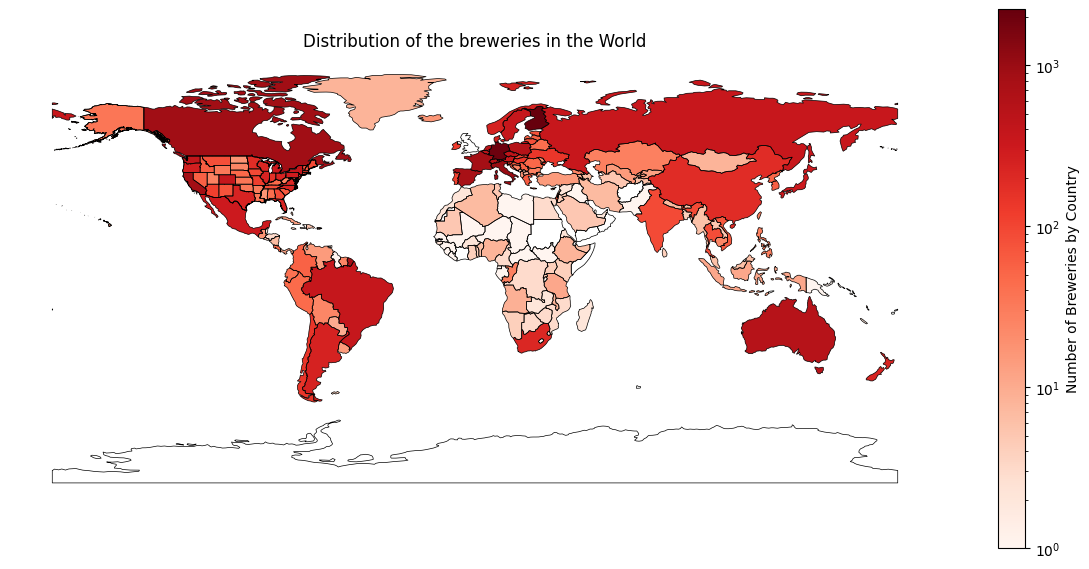

In [37]:
# Count the number of breweries in each country
brewery_counts = breweries_loc['brewery_state'].value_counts().reset_index()
brewery_counts.columns = ['brewery_state', 'nb_breweries']

# Merge brewery counts with the world map data
world_merge = world_with_US_states.merge(brewery_counts, how='left', left_on='name', right_on='brewery_state')

# Fill NaN values (countries without breweries) with 0
world_merge['nb_breweries'].fillna(0, inplace=True)
# Fill NaN values of state with Unknown
world_merge['brewery_state'].fillna('Unknown', inplace=True)

# Find top 10 countries
top10 = world_merge.sort_values(by='nb_breweries', ascending=False).head(10)
top10 = top10[['name', 'nb_breweries']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_breweries = top10.nb_breweries.astype(int)

# Display the Top 10 countries (considering US states) with the most breweries
print('Top 10 countries (considering US states) with the most breweries:')
display(top10)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
world_merge.boundary.plot(ax=ax, color='black', linewidth=0.5)
world_merge.plot(column='nb_breweries', ax=ax, legend=True,
                 norm=LogNorm(vmin=1, vmax=world_merge['nb_breweries'].max()),
                 legend_kwds={'label': "Number of Breweries by Country",
                              'orientation': "vertical"},
                 cmap='Reds')

# Remove the axis
ax.set_title('Distribution of the breweries in the World')
ax.set_axis_off()
plt.show()


The revised analysis reveals distinct results. Germany takes the lead, followed by Finland, and several US states are now present in the Top 10. The conclusion of this analysis is that there are many more breweries in the US than anywhere else in the world. Acknowledging this, it becomes essential to consider the US's internal diversity in subsequent analyses. Given the availability of information about individual US states, incorporating them into the analysis could provide valuable insights, offering a more nuanced understanding of the brewing landscape within the country.

### **2.3.2 Spatial Distribution of the Users**
Now that we have gained insights into the distribution of breweries worldwide, we can apply a **similar analysis** to the **user data**. The aim of this analysis is to see whether or not a geographical similarity can be observed between the distribution of breweries and the distribution of users who give reviews. Once again, a matching process based on Hamming's distance must be performed to match the names of the different places.

In [38]:
# Create a copy of the filtered users dataset and reset indexes (needed for the loop next)
users_loc = users_filt.copy(deep=True)
users_loc.reset_index(inplace=True,drop=True)
# Create a column for the state in the users dataframe, to be used for USA
users_loc['state'] = '-'
users_loc.rename(columns={'user_location': 'country'}, inplace=True)
# Init dropped breweries
#dropped_brew = []
users_loc, dropped_user = helpfn.match_country_name(users_loc,
                                             unique_loc,
                                             unique_state)

# Display a sample of the modified dataframe
users_loc.rename(columns={'country':'user_country','state':'user_state'}, inplace=True)

# Display a sample of the modified users dataframe
display(users_loc.sample(3))

# Print the number of dropped users and their locations
print(f'{len(dropped_user)} users were dropped, at the following location:')
print(dropped_user)

,nbr_reviews,user_id,user_name,joined,user_country,user_state
49278,2,98025,breezer,2009-11-24 11:00:00,Sweden,Sweden
43310,1,88503,Smashley,2009-03-09 11:00:00,United States of America,Florida
22619,2,306570,Rockyhead,2014-03-06 11:00:00,Australia,Australia


29 users were dropped, at the following location:
['Isle of Man', 'Virgin Islands (U.S.)', 'Isle of Man', 'Ivory Coast', 'Virgin Islands (U.S.)', 'Liechtenstein', 'Isle of Man', 'East Timor', 'Nagorno-Karabakh', 'Tuvalu', 'Isle of Man', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Isle of Man', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Virgin Islands (U.S.)', 'Isle of Man', 'Isle of Man', 'Saint Vincent and The Grenadines', 'Virgin Islands (British)']


Let's examine the **Top 10 countries** with the **highest number of reviewers** to gain insights into the global distribution of reviewers.

In [40]:
# Count the number of reviewers in each country
reviewers_counts = users_loc['user_country'].value_counts().reset_index()
reviewers_counts.columns = ['user_country', 'nb_reviewers']

# Identify the top 10 countries according to the number of reviewers
top10 = reviewers_counts.sort_values(by='nb_reviewers', ascending=False).head(10)
top10 = top10[['user_country', 'nb_reviewers']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_reviewers = top10.nb_reviewers.astype(int)

# Display the Top 10 countries with the most reviewers
print('Top 10 countries with the most reviewers:')
display(top10)

Top 10 countries with the most reviewers:


,user_country,nb_reviewers
1,United States of America,26855
2,Canada,3255
3,Finland,3187
4,Poland,2079
5,Australia,1476
6,Netherlands,1095
7,Denmark,1031
8,Belgium,1027
9,Sweden,1004
10,Italy,924


As observed, there is once again a **substantial number of reviewers in the US**. The distribution seems fairly similar to that observed for breweries. In the next section, we will **replicate the analysis**, this time considering reviewers based on **US states**.

Top 10 countries (considering US states) with the most reviewers:


,name,nb_reviewers
1,Canada,3255
2,Finland,3187
3,California,2804
4,Poland,2079
5,Pennsylvania,1632
6,Australia,1476
7,Texas,1423
8,Illinois,1406
9,New York,1352
10,Florida,1269


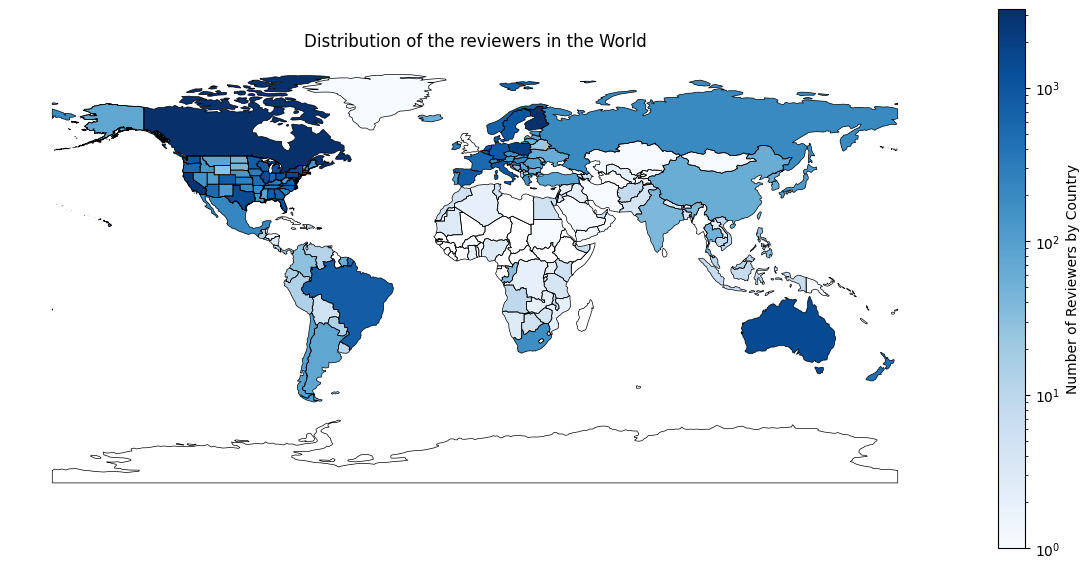

In [41]:
# Count the number of reviewers in each country
reviewers_counts = users_loc['user_state'].value_counts().reset_index()
reviewers_counts.columns = ['user_state', 'nb_reviewers']

# Merge reviewer counts with the world map data
world_merge = world_with_US_states.merge(reviewers_counts, how='left', left_on='name', right_on='user_state')

# Fill NaN values (countries without reviewers) with 0
world_merge['nb_reviewers'].fillna(0, inplace=True)
world_merge['user_state'].fillna('Unknown', inplace=True)

# Identify the top 10 countries
top10 = world_merge.sort_values(by='nb_reviewers', ascending=False).head(10)
top10 = top10[['name', 'nb_reviewers']]
top10.index = np.linspace(1, 10, 10).astype(int)
top10.nb_reviewers = top10.nb_reviewers.astype(int)

# Display the Top 10 countries (considering US states) with the most reviewers
print('Top 10 countries (considering US states) with the most reviewers:')
display(top10)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
world_merge.boundary.plot(ax=ax, color='black', linewidth=0.5)
world_merge.plot(column='nb_reviewers', ax=ax, legend=True,
                 norm=LogNorm(vmin=1, vmax=world_merge['nb_reviewers'].max()),
                 legend_kwds={'label': "Number of Reviewers by Country", 'orientation': "vertical"},
                 cmap='Blues')

# Remove the axis
ax.set_title('Distribution of the reviewers in the World')
ax.set_axis_off()
plt.show()


We can see that **the majority of reviewers are concentrated in the USA**. In fact, not only the majority of breweries but also the vast majority of reviewers are located in the USA. This is crucial for the analysis of the spatial distribution of the reviewers since the non-US breweries will by definition receive a majority of reviews from reviewers in the USA, and thus obtain larger mean distance of reviews.

# **3. Global Analysis**
In this chapter, we proceed to the final analysis with the aim of answering our research questions:

- Is there any relationship between brewery size and the perceived quality of their products?
- Do larger breweries tend to please a broader, potentially less sophisticated consumer base, while smaller breweries may craft more specialized, polarizing products, that resonate with a niche audience of enthusiasts?
- Are there any evolutions or differences over the years?
- Do big breweries tend to please a broader audience (spatial dimension) than smaller ones?

## **3.1 Ratings vs Size**

We will now investigate whether and how the size impacts the average rating obtained by the breweries.

A priori, one might expect the scores obtained by small breweries to be fairly evenly distributed, ranging from very bad to very good, depending on taste, with potentially more polarizing flavours. On the other hand, in the case of large breweries with an international reach, one might expect the ratings to cluster more closely, reflecting products that are more polished and accomplished.

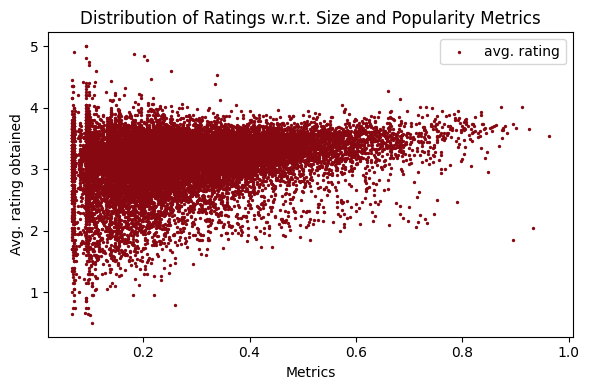

In [42]:
df_rating_analysis = df_metrics_macro.copy(deep=True)

# Create figure for size vs average rating plot
plt.figure(figsize=(6, 4))

point_size = 2

# Plot scatter 'size_metrics_macro'
plt.scatter(df_rating_analysis['size_metrics_macro'], df_rating_analysis['avg_rating_macro'], color='#880812', label='avg. rating', s=point_size)


# Plot settings
plt.title('Distribution of Ratings w.r.t. Size and Popularity Metrics')
plt.ylabel('Avg. rating obtained')
plt.xlabel('Metrics')
plt.legend()
plt.tight_layout()
plt.show()

It can be observed that the distribution is highly dispersed for smaller breweries, covering almost the entire range of scores. In contrast, the average score obtained by larger breweries appears slightly higher and less spread out.

We discretize the size metrics by interval of size 0.05 in order to see the rating trend with respect to the size.

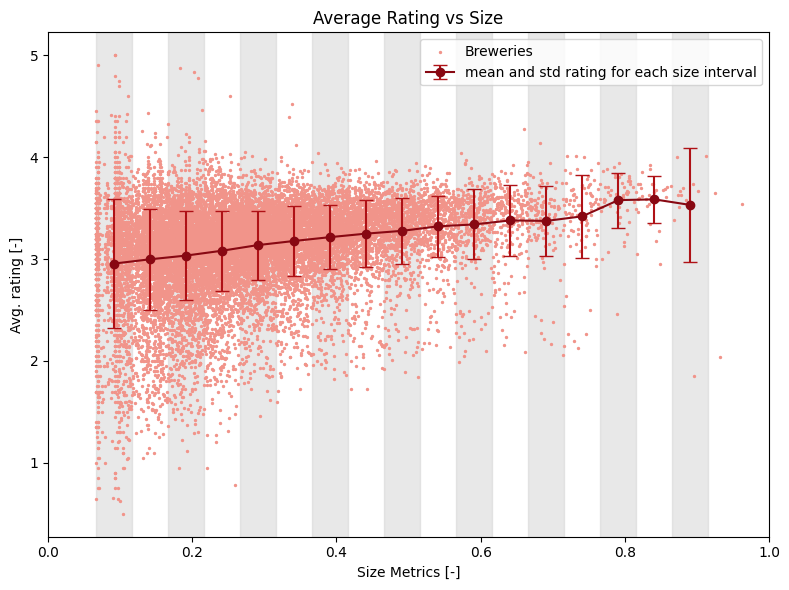

In [43]:
# Define the size interval width
interval_width = 0.05

# Calculate the minimum and maximum size values to determine the range
min_size = df_rating_analysis['size_metrics_macro'].min()
max_size = df_rating_analysis['size_metrics_macro'].max()

# Create intervals for size
size_intervals = pd.interval_range(start=min_size, end=max_size, freq=interval_width)

# Assign each row to its corresponding interval
df_rating_analysis['interval'] = pd.cut(df_rating_analysis['size_metrics_macro'], bins=size_intervals)

mean_std_rating_by_size = df_rating_analysis.groupby('interval')['avg_rating_macro'].agg(['mean', 'std']).reset_index()
# Middle points of the size metric intervals
mean_std_rating_by_size['midpoints'] = mean_std_rating_by_size['interval'].apply(lambda x: x.mid)

plt.figure(figsize=(8, 6))

for i in range(len(mean_std_rating_by_size)):
    if i % 2 == 0:
        plt.axvspan(mean_std_rating_by_size['interval'][i].left, mean_std_rating_by_size['interval'][i].right, color='lightgray', alpha=0.5)
    
plt.scatter(df_rating_analysis['size_metrics_macro'], df_rating_analysis['avg_rating_macro'], color=pastel_red,label='Breweries', s=point_size)
plt.errorbar(mean_std_rating_by_size['midpoints'], mean_std_rating_by_size['mean'], yerr=mean_std_rating_by_size['std'], fmt='o-', color='#880812', ecolor='#AF1116', label='mean and std rating for each size interval', capsize=5)
plt.title(f'Average Rating vs Size')
plt.xlabel('Size Metrics [-]')
plt.ylabel('Avg. rating [-]')
plt.xlim([0,1])
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

We observe a fairly linear increase in the mean rating as the size metric rises, along with a reduction in the standard deviation. 

Accordingly, **larger breweries tend to receive higher overall ratings and exhibit more homogeneous scores**. This is the same conclusion as in the case of BeerAdvocate.

### **3.1.1 Regression analysis**

To examine whether a linear relationship exists between **the size metrics and the average rating** obtained by the breweries, we conduct a **linear regressio**n on the raw distribution.

In [44]:
model_continous = smf.ols(formula='avg_rating_macro ~ size_metrics_macro', data=df_rating_analysis).fit()
print(model_continous.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_rating_macro   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1421.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          5.38e-300
Time:                        11:42:49   Log-Likelihood:                -10741.
No. Observations:               19052   AIC:                         2.149e+04
Df Residuals:                   19050   BIC:                         2.150e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8892      0

**There is a positive linear correlation** between size metrics and the average rating obtained by a brewery. However, the $R^2 = 0.069$ value indicates that **this regression poorly explains the correlation**. This is expected given the very large standard deviation of the average ratings obtained by small breweries

If we consider the case where the rating is averaged by metric size, the linear correlation is, as expected, much stronger.

In [45]:
model_discret = sm.OLS(mean_std_rating_by_size['mean'], mean_std_rating_by_size['midpoints']).fit()
print(model_discret.summary())

                                 OLS Regression Results                                
Dep. Variable:                   mean   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              86.67
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                    7.36e-08
Time:                        11:42:54   Log-Likelihood:                         -28.511
No. Observations:                  17   AIC:                                      59.02
Df Residuals:                      16   BIC:                                      59.85
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\begue\Desktop\ADA\ADAenv\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


However, **we must remain cautious** with these results, as **it is likely that other confounders, not taken into account, have an impact on the average rating obtained by the breweries**. 

It is therefore likely that **the size index does not explain everything.**

### **3.1.2 Hypothesis testing**

Now that we have observed the distribution and general trend of the average rating in relation to the size metrics, it is interesting to investigate whether belonging to one of the small, medium, or big categories explains the average rating in a statistically significant way. 

To achieve this, **we perform a Student's t-test on the average rating between the small/medium and medium/big categories**. 

We conduct an unpaired t-test at the $0.05$ significance level under the hypothesis $H_0$: **there is no statistically significant difference** in average ratings between the brewery size categories.

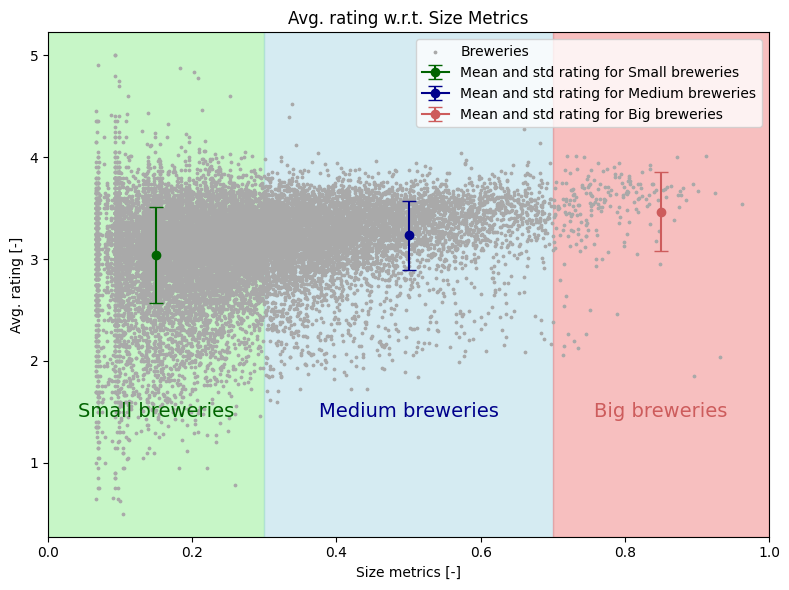

Average rating for the small breweries: 3.04 with std: 0.473
Average rating for the medium breweries: 3.23 with std: 0.337
Average rating for the big breweries: 3.47 with std: 0.391
T-statistic: -32.6744
P-value: 2.0801482e-227
The difference in avg. rating is statistically significant between small and medium breweries.
T-statistic: -8.4688
P-value: 0.00000000
The difference in avg. rating is statistically significant between medium and big breweries.


In [46]:
# Create lists for means and standard deviations
means, std_devs = helpfn.compute_stats_for_categories(df_rating_analysis, 'avg_rating_macro')
labels = ['Small', 'Medium', 'Big']
colors = ['lightgreen', 'lightblue', 'lightcoral']
dark_colors = ['darkgreen', 'darkblue', 'indianred']

# Define size intervals and midpoints
size = [0, 0.3, 0.7, 1.0]
mid = [0.15, 0.5, 0.85]
point_size = 3

# Create a figure
plt.figure(figsize=(8, 6))
labels = ['Small breweries', 'Medium breweries', 'Big breweries']
text_positions = zip(mid, [1.5, 1.5, 1.5], labels, dark_colors)

# Plot background color spans for size categories
for i in range(len(size)-1):
    plt.axvspan(size[i], size[i+1], color=colors[i], alpha=0.5)

# Plot mean and standard deviation for each size category
for i in range(len(size)-1):
    plt.errorbar(mid[i], means[i], yerr=std_devs[i], fmt='o-', color=dark_colors[i], ecolor=dark_colors[i],
                 label='Mean and std rating for '+labels[i], capsize=5, alpha=1.0)
    for pos in text_positions:
        plt.text(pos[0], pos[1], pos[2], color=pos[3], ha='center', va='center', fontsize=14)

# Scatter plot for individual breweries
plt.scatter(df_rating_analysis['size_metrics_macro'], df_rating_analysis['avg_rating_macro'], color='darkgray',
            label='Breweries', s=point_size)

# Plot settings
plt.legend(loc='upper right')
plt.title('Avg. rating w.r.t. Size Metrics')
plt.xlabel('Size metrics [-]')
plt.ylabel('Avg. rating [-]')
plt.xlim([0, 1])

plt.tight_layout()
plt.show()

# Print average ratings and standard deviations for each size category
print('Average rating for the small breweries: {:.3g} with std: {:.3g}'.format(means[0], std_devs[0]))
print('Average rating for the medium breweries: {:.3g} with std: {:.3g}'.format(means[1], std_devs[1]))
print('Average rating for the big breweries: {:.3g} with std: {:.3g}'.format(means[2], std_devs[2]))

# Hypothesis testing for small vs. medium breweries
t_statistic, p_value = stats.ttest_ind(df_rating_analysis[df_rating_analysis['size_category']=='small']['avg_rating_macro'],
                                       df_rating_analysis[df_rating_analysis['size_category']=='medium']['avg_rating_macro'],
                                       equal_var=False)

# Significance level
alpha = 0.05

print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.8}")

# Interpretation of the test results
if p_value < alpha:
    print("The difference in avg. rating is statistically significant between small and medium breweries.")
else:
    print("The difference in avg. rating is not statistically significant between small and medium breweries.")

# Hypothesis testing for medium vs. big breweries
t_statistic, p_value = stats.ttest_ind(df_rating_analysis[df_rating_analysis['size_category']=='medium']['avg_rating_macro'],
                                       df_rating_analysis[df_rating_analysis['size_category']=='big']['avg_rating_macro'],
                                       equal_var=False)

# Significance level
alpha = 0.05

print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.8f}")

# Interpretation of the test results
if p_value < alpha:
    print("The difference in avg. rating is statistically significant between medium and big breweries.")
else:
    print("The difference in avg. rating is not statistically significant between medium and big breweries.")


It can be seen that belonging to a larger category tends to significantly increase the average rating obtained (at a significance level of 0.05). 

An average rating difference of almost 0.4 can be observed between small and large breweries. However, we must be careful, as the standard deviation remains quite high. 

**In conclusion, bigger breweries obtain higher average ratings, and there are fewer differences in their ratings than for the smaller breweries**. However, by examining the plot, we can see that **some small breweries obtain very high ratings that are not achieved by big breweries**. 

This is evident in the following table, which displays the breweries with the 15 highest average ratings.

In [47]:
top15= df_rating_analysis[['brewery_id','avg_rating_macro','size_category']].sort_values('avg_rating_macro',ascending=False).head(15).reset_index(drop=True)
top15.index = np.linspace(1, 15, 15).astype(int)
display(top15)

,brewery_id,avg_rating_macro,size_category
1,26827,5.000000,small
2,27845,5.000000,small
3,29738,4.900000,small
4,11664,4.875000,small
5,11101,4.840000,small
6,26394,4.800000,small
7,1360,4.775000,small
8,30624,4.750000,small
9,30134,4.700000,small
10,23116,4.600000,small


We can indeed see that 14 of the 15 breweries with the highest average ratings are categorized as `small` breweries. 

**This indicates that, despite the fact that larger breweries, on average, have higher ratings, the perceived quality of their products is not as high as that of the best small breweries**. This is the same conclusion as in the case of BeerAdvocate.

### **3.1.3 Is there a difference over the years?**

It is now legitimate to question the temporal robustness of this result. Can the same conclusion be drawn in 2005, 2010, and 2016? To explore this, we conduct the same analysis of the average rating across the three size categories over these years.

In [48]:
# Copy the original dataframe for temporal analysis
df_temporal = df_metrics.copy(deep=True)

# Specify the list of years for analysis
years_list = [2005, 2010, 2016]

# Initialize dictionaries to store dataframes, means, and standard deviations
dfs = {} 
means = {}
stds = {}

# Loop through each year in the specified list
for year in years_list:
    # Filter dataframes for small, medium, and big breweries for the given year
    dfs[f"df_small_breweries_{year}"] = df_temporal[(df_temporal['size_category']=='small') & (df_temporal['date']==year)]
    dfs[f"df_medium_breweries_{year}"] = df_temporal[(df_temporal['size_category']=='medium') & (df_temporal['date']==year)]
    dfs[f"df_big_breweries_{year}"] = df_temporal[(df_temporal['size_category']=='big') & (df_temporal['date']==year)]

    # Calculate means and standard deviations for small breweries
    means[f"mean_small_{year}"] = dfs[f'df_small_breweries_{year}']['avg_rating'].mean()
    stds[f"std_small_{year}"] = dfs[f'df_small_breweries_{year}']['avg_rating'].std()

    # Calculate means and standard deviations for medium breweries
    means[f"mean_medium_{year}"] = dfs[f'df_medium_breweries_{year}']['avg_rating'].mean()
    stds[f"std_medium_{year}"] = dfs[f'df_medium_breweries_{year}']['avg_rating'].std()

    # Calculate means and standard deviations for big breweries
    means[f"mean_big_{year}"] = dfs[f'df_big_breweries_{year}']['avg_rating'].mean()
    stds[f"std_big_{year}"] = dfs[f'df_big_breweries_{year}']['avg_rating'].std()


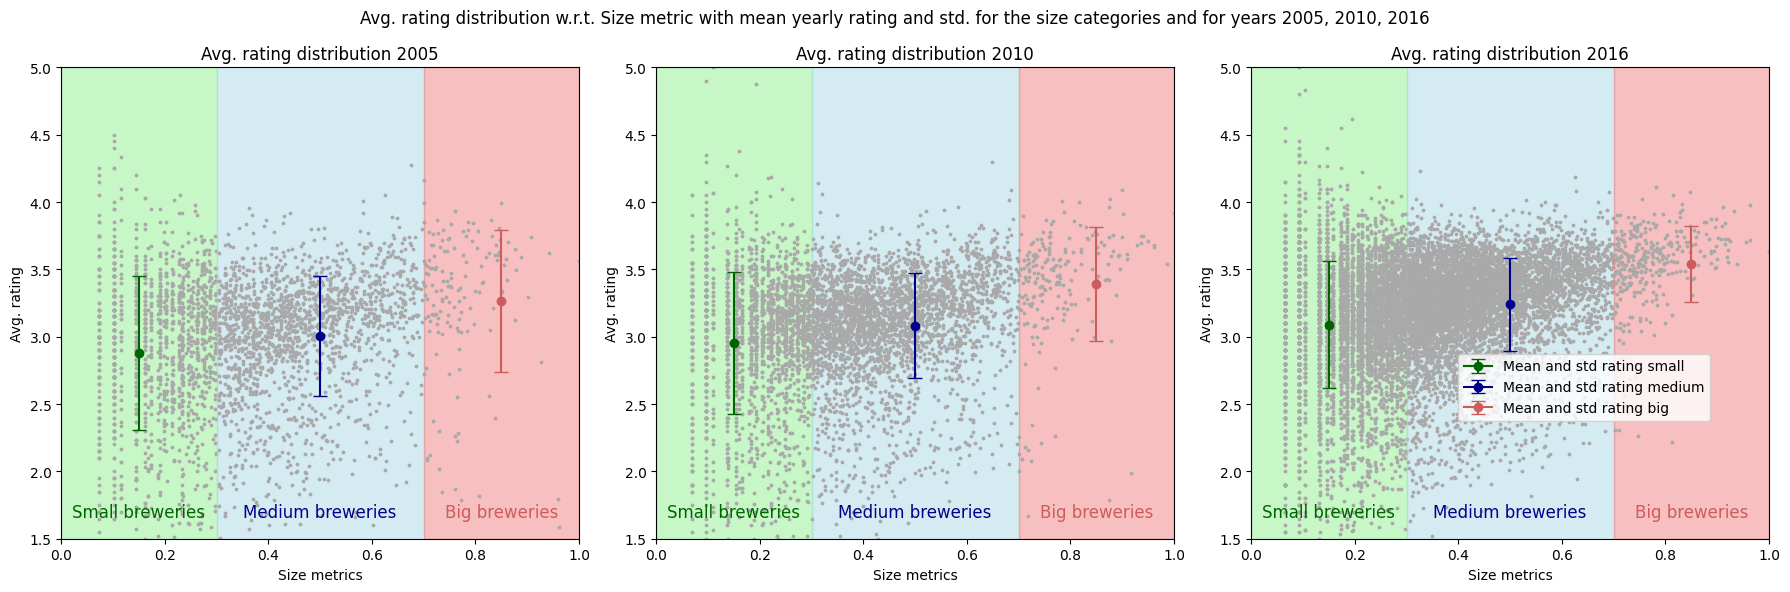

Mean rating for the small breweries in 2005: 2.882 with std: 0.5724
Mean rating for the medium breweries in 2005: 3.004 with std: 0.4453
Mean rating for the big breweries in 2005: 3.265 with std: 0.5253


Mean rating for the small breweries in 2010: 2.955 with std: 0.528
Mean rating for the medium breweries in 2010: 3.081 with std: 0.3896
Mean rating for the big breweries in 2010: 3.391 with std: 0.4219


Mean rating for the small breweries in 2016: 3.09 with std: 0.4713
Mean rating for the medium breweries in 2016: 3.239 with std: 0.3474
Mean rating for the big breweries in 2016: 3.539 with std: 0.2839




In [49]:
# Define categories, labels, and colors for plotting
categories = ['small', 'medium', 'big']
labels = ['Small breweries', 'Medium breweries', 'Big breweries']
colors = ['lightgreen', 'lightblue', 'lightcoral']
dark_colors = ['darkgreen', 'darkblue', 'indianred']
size = [0, 0.3, 0.7, 1.0]
mid = [0.15, 0.5, 0.85]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Function to plot on a subplot
def plot_on_subplot(ax, j):
    for i in range(len(size) - 1):
        # Plot background color spans for size categories
        ax.axvspan(size[i], size[i + 1], color=colors[i], alpha=0.5)
        
        # Plot mean and standard deviation for each size category and year
        ax.errorbar(mid[i], means[f"mean_{categories[i]}_{years_list[j]}"],
                    yerr=stds[f"std_{categories[i]}_{years_list[j]}"], fmt='o-', color=dark_colors[i],
                    ecolor=dark_colors[i], label='Mean and std rating ' + str(categories[i]),
                    capsize=5, alpha=1.0)
        
        # Scatter plot for individual breweries' rating distribution
        ax.scatter(dfs[f"df_{categories[i]}_breweries_{years_list[j]}"]['size_metrics'],
                   dfs[f"df_{categories[i]}_breweries_{years_list[j]}"]['avg_rating'], color='darkgray', s=point_size)
        
        # Label each category
        ax.text(mid[i], 1.7, labels[i], color=dark_colors[i], ha='center', va='center', fontsize=12)

        # Set subplot properties
        ax.set_title('Avg. rating distribution ' + str(years_list[j]))
        ax.set_ylim([1.5, 5])
        ax.set_xlim([0, 1])
        ax.set_xlabel('Size metrics')
        ax.set_ylabel('Avg. rating')

# Iterate over subplots and plot data
for j, ax in enumerate(axs):
    plot_on_subplot(ax, j)

# Add legend and title
plt.legend(loc=(0.4, 0.25))
plt.suptitle('Avg. rating distribution w.r.t. Size metric with mean yearly rating and std. for the size categories and for years 2005, 2010, 2016')
plt.tight_layout()
plt.show()

# Print mean and std for each size category and year
for year in years_list:
    print(f"Mean rating for the small breweries in {year}: {means[f'mean_small_{year}']:.4g} with std: {stds[f'std_small_{year}']:.4g}")
    print(f"Mean rating for the medium breweries in {year}: {means[f'mean_medium_{year}']:.4g} with std: {stds[f'std_medium_{year}']:.4g}")
    print(f"Mean rating for the big breweries in {year}: {means[f'mean_big_{year}']:.4g} with std: {stds[f'std_big_{year}']:.4g}")
    print("\n")


We observe that the same conclusion, as discussed in section 3.1.2, applies to all years. 

**Belonging to a larger category tends to increase the average rating obtained.** Thus, there is no significant temporal evolution in this analysis.

## **3.2 Review length vs. brewery size analysis**

Now, we can perform the same analysis to investigate whether the brewery size metrics impact the average review length obtained by the breweries.

### **3.2.1 Hypothesis Testing**
We perform an unpaired t-test at the 0.05 significance level under the hypothesis 
- $H_0$ : **there is no statistically significant difference in average review length between the brewery size categories**. 

This helps us determine whether the size category of a brewery impacts the average review length obtained

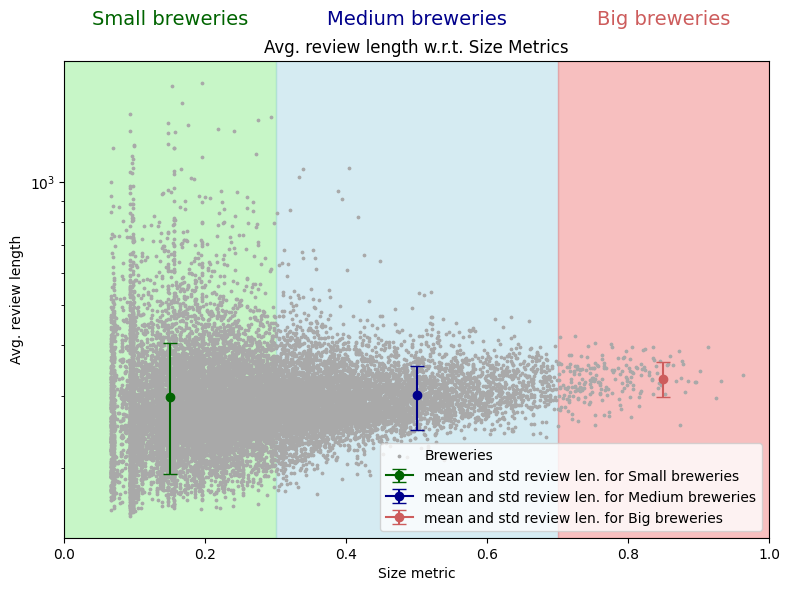

Average review length for the small breweries:  298.6111259780546 with std:  105.30701287907164
Average review length for the medium breweries:  301.5752202767457 with std:  53.79136321598789
Average review length for the big breweries:  330.1601852568935 with std:  32.85948826675854
T-statistic: -2.5561
P-value: 0.01059329
The difference in avg. review length is statistically significant between small and medium breweries.
T-statistic: -12.0262
P-value: 0.00000000
The difference in avg. review length is statistically significant between medium and big breweries.


In [50]:
# Make a copy of the DataFrame
df_review_len = df_metrics_macro.copy(deep=True)

# Compute means and standard deviations for review lengths across size categories
means_rew_len, std_devs_rew_len = helpfn.compute_stats_for_categories(df_review_len, 'avg_len_text_macro')

# Define labels and colors for plotting
labels = ['Small', 'Medium', 'Big']
colors = ['lightgreen', 'lightblue', 'lightcoral']
dark_colors = ['darkgreen', 'darkblue', 'indianred']
size = [0, 0.3, 0.7, 1.0]
mid = [0.15, 0.5, 0.85]

plt.figure(figsize=(8, 6))

# Define labels for plot and their positions
labels = ['Small breweries', 'Medium breweries', 'Big breweries']
text_positions = zip(mid, [2500, 2500, 2500], labels, dark_colors)

# Plot error bars for means and standard deviations for each size category
for i in range(len(size) - 1):
    plt.axvspan(size[i], size[i + 1], color=colors[i], alpha=0.5)
    plt.errorbar(mid[i], means_rew_len[i], yerr=std_devs_rew_len[i], fmt='o-', color=dark_colors[i],
                 ecolor=dark_colors[i], label='mean and std review len. for ' + labels[i], capsize=5, alpha=1.0)

    # Add text labels at specified positions
    for pos in text_positions:
        plt.text(pos[0], pos[1], pos[2], color=pos[3], ha='center', va='center', fontsize=14)

# Scatter plot for review length distribution
plt.scatter(df_review_len['size_metrics_macro'], df_review_len['avg_len_text_macro'], color='darkgray', label='Breweries', s=point_size)
plt.legend(loc='lower right')
plt.title('Avg. review length w.r.t. Size Metrics')
plt.yscale('log')
plt.xlim([0, 1])
plt.xlabel('Size metric')
plt.ylabel('Avg. review length')
plt.tight_layout()
plt.show()

# Print mean and standard deviation for each size category
print('Average review length for the small breweries: ', means_rew_len[0], 'with std: ', std_devs_rew_len[0])
print('Average review length for the medium breweries: ', means_rew_len[1], 'with std: ', std_devs_rew_len[1])
print('Average review length for the big breweries: ', means_rew_len[2], 'with std: ', std_devs_rew_len[2])

# Hypothesis testing for differences in review length between size categories
t_statistic, p_value = stats.ttest_ind(df_review_len[df_review_len['size_category'] == 'small']['avg_len_text_macro'],
                                       df_review_len[df_review_len['size_category'] == 'medium']['avg_len_text_macro'],
                                       equal_var=False)

# Significance level
alpha = 0.05

print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.8f}")

if p_value < alpha:
    print("The difference in avg. review length is statistically significant between small and medium breweries.")
else:
    print("The difference in avg. review length is not statistically significant between small and medium breweries.")

t_statistic, p_value = stats.ttest_ind(df_review_len[df_review_len['size_category'] == 'medium']['avg_len_text_macro'],
                                       df_review_len[df_review_len['size_category'] == 'big']['avg_len_text_macro'],
                                       equal_var=False)

# Significance level
alpha = 0.05

print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.8f}")

if p_value < alpha:
    print("The difference in avg. review length is statistically significant between medium and big breweries.")
else:
    print("The difference in avg. review length is not statistically significant between medium and big breweries.")


We can observe that **the differences in review lengths are significant at the 0.05 significance level**. 

However, similar to the rating case, it is interesting to note that **the longest reviews are given to small breweries**. This suggests that some small breweries have reviewers who provide more sophisticated reviews compared to those for bigger breweries. This is the same conclusion as in the case of BeerAdvocate.

## **3.3 Geographical Distribution of Reviewers vs Size**

### **3.3.1 Relative distance between Reviewers and Breweries**

Our next focus is to **explore the relative distance between the reviewer and the brewery for each review**. This analysis aims to provide insights into **how the popularity of a brewery is distributed globally**.

To achieve this, we begin by calculating the centroid of each country (or state in the case of US). Subsequently, we can compute the distance between the countries/state.

In [51]:
# Add centroid to world dataset
world_df = world_with_US_states.copy(deep=True)
world_df = world_df.to_crs(3857)
world_df['centroids'] = world_df['geometry'].centroid.to_crs(4326)
world_df = world_df.reset_index(drop=True)
display(world_df.sample(3))

,name,geometry,centroids
74,Angola,"MULTIPOLYGON (((1446654.358 -532848.725, 14061...",POINT (17.47320 -12.30289)
16,Haiti,"POLYGON ((-7982983.556 2239234.808, -7973244.4...",POINT (-72.65716 18.90345)
21,Norway,"MULTIPOLYGON (((1685691.012 15333216.867, 1727...",POINT (16.77927 73.74039)


In [ ]:
warnings.filterwarnings("ignore")
# Create an empty DataFrame to store distances
distances_df = pd.DataFrame(index=world_df['name'], columns=world_df['name'])

# Calculate distances for each pair of countries
for i in range(len(world_df)):
    for j in range(i + 1, len(world_df)):
        country1 = world_df.loc[i, 'name']
        country2 = world_df.loc[j, 'name']
        lat1, lon1 = gpd.GeoSeries(world_df.loc[i, 'centroids']).y, gpd.GeoSeries(world_df.loc[i, 'centroids']).x
        lat2, lon2 = gpd.GeoSeries(world_df.loc[j, 'centroids']).y, gpd.GeoSeries(world_df.loc[j, 'centroids']).x
        
        # Compute haversine distance
        distance = helpfn.haversine(lat1, lon1, lat2, lon2)
        
        # Fill both entries since the distance is symmetric
        distances_df.at[country1, country2] = distance
        distances_df.at[country2, country1] = distance
warnings.resetwarnings()


In [53]:
# Merge the brewery/user location and state with reviews
review_brew_user = reviews_filt[['brewery_id','user_id','date']].copy(deep=True)
review_brew_user = pd.merge(review_brew_user,breweries_loc[['brewery_id','brewery_country','brewery_state']],on=['brewery_id'],how='inner')
review_brew_user = pd.merge(review_brew_user,users_loc[['user_id','user_country','user_state']],on=['user_id'],how='inner')
display(review_brew_user.sample(3))

,brewery_id,user_id,date,brewery_country,brewery_state,user_country,user_state
925560,11233,7513,2015,United States of America,Vermont,Denmark,Denmark
1361204,10818,11905,2010,United States of America,Arizona,Canada,Canada
1596136,1805,37760,2009,Belgium,Belgium,Denmark,Denmark


Now that we have a dataframe containing every review, along with the location of the reviewed brewery and the user's residence, we can incorporate the previously computed distances into the dataframe.

In [54]:
rev_distance = review_brew_user.copy(deep=True)
# Create new column with distance between reviewer and the brewery for each review
rev_distance['distance_state'] = rev_distance.apply(lambda row: distances_df.loc[row.brewery_state,row.user_state],axis=1)
# Replace the NaN by 0, (the distance between the same country is set to NaN by defintion (distance(belgium,belgium) = NaN))
rev_distance = rev_distance.fillna(0)
display(rev_distance.sample(3))

,brewery_id,user_id,date,brewery_country,brewery_state,user_country,user_state,distance_state
2914680,17007,125231,2016,Belgium,Belgium,Belgium,Belgium,0.0
4984119,84,13355,2005,United States of America,Missouri,United States of America,Missouri,0.0
2435313,2939,25787,2007,Denmark,Denmark,Denmark,Denmark,0.0


Let's have a look to the distribution of the distances.

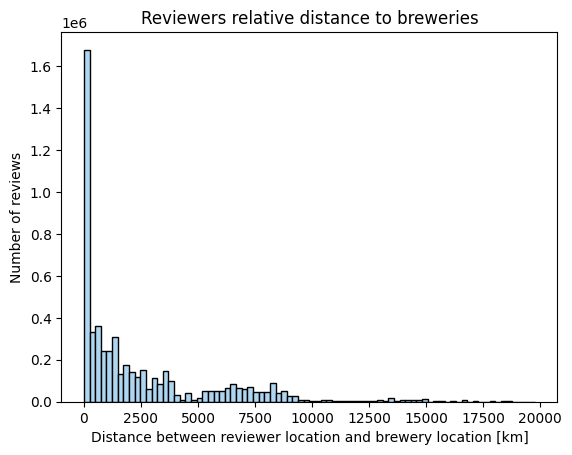

In [56]:
rev_dist = rev_distance.copy(deep=True)
# Plot a histogram of the distances between reviewer and brewery locations
plt.hist(rev_dist['distance_state'], bins=80, color=pastel_blue, edgecolor='black')

# Set x and y labels and the title
plt.xlabel('Distance between reviewer location and brewery location [km]')
plt.ylabel('Number of reviews')
plt.title('Reviewers relative distance to breweries')

# Display the plot
plt.show()

The graph showing the distribution of relative distances between reviewers and breweries for each review is quite diverse, with a majority of users reviewing 'local' beers (those that come from the same state/country). 

Additionally, there is a large proportion of reviews between 0 and 8000 km, notably corresponding to intra-USA reviews.

### **3.3.2 Is there a relation between the size and the spatial distribution of the reviewers?**

It's now interesting to **examine the relative distance of reviewers for a given brewery based on its size**. This investigation will help discern whether a small local brewery receives a majority of reviews from nearby users or if a world-renowned brewery receives international reviews, resulting in a higher average distance. 

Since the vast majority of reviewers are located in the USA, **we decided to restrict this analysis to the USA**. This means we will only consider breweries on American soil. This restriction is necessary as non-American breweries will receive most of their reviews from American users, leading to larger distances.

First and foremost, we need to populate the distance dataframe with information on brewery size.

In [57]:
# Merge distance and metrics dataframes on 'brewery_id'
metric_distance = pd.merge(rev_dist[['brewery_id', 'distance_state','brewery_country','user_country']],
                          df_metrics_macro[['brewery_id', 'size_metrics_macro', 'popularity_metrics_macro','size_category']],
                          on=['brewery_id'], how='inner')

display(metric_distance.sample(3))

,brewery_id,distance_state,brewery_country,user_country,size_metrics_macro,popularity_metrics_macro,size_category
967419,1086,1928.003511,Sweden,Switzerland,0.693036,0.060995,medium
2169180,7043,3681.743766,United States of America,Canada,0.834655,0.064805,big
3434824,2514,299.168388,United States of America,United States of America,0.668015,0.086159,medium


In [58]:
# Keep only US breweries
USA_metric_dist = metric_distance[metric_distance['brewery_country']=='United States of America']

We will look to the average distance of the reviewers for each brewery.

In [59]:
# Group by 'brewery_id' and calculate the mean distance of the reviewers
USA_mean = USA_metric_dist.groupby('brewery_id').agg({
    'brewery_country': 'first', 
    'distance_state': 'mean',
    'user_country': 'first', 
    'size_metrics_macro': 'first',
    'size_category': 'first',
    'popularity_metrics_macro': 'first'
}).reset_index()

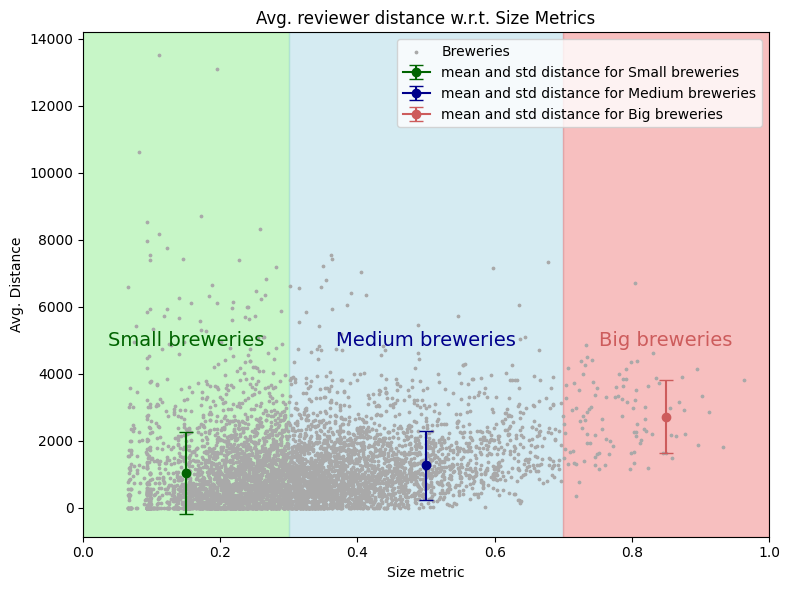

Macro-average of the reviewer distance for the small breweries:  1032.113235760154 with std:  1220.0376754170186
Macro-average of the reviewer distance for the medium breweries:  1263.998615001102 with std:  1031.0642795697186
Macro-average of the reviewer distance for the big breweries:  2711.2162585699566 with std:  1091.5745852002742


In [60]:
# Create lists for means and standard deviations
means, std_devs = helpfn.compute_stats_for_categories(USA_mean,'distance_state')
labels = ['Small', 'Medium', 'Big']
colors = ['lightgreen', 'lightblue', 'lightcoral']
dark_colors  = ['darkgreen', 'darkblue', 'indianred']
size = [0, 0.3, 0.7, 1.0]
mid = [0.15, 0.5, 0.85]

# Set up the plot
plt.figure(figsize=(8, 6))
labels = ['Small breweries', 'Medium breweries', 'Big breweries']
text_positions = zip(mid, [5000, 5000, 5000], labels, dark_colors)

# Iterate over brewery size categories
for i in range(len(size)-1):
    # Highlight the size categories with different colors
    plt.axvspan(size[i], size[i+1], color=colors[i], alpha=0.5)
    
    # Plot mean and standard deviation with error bars
    plt.errorbar(mid[i], means[i], yerr=std_devs[i], fmt='o-', color=dark_colors[i], ecolor=dark_colors[i], label='mean and std distance for '+labels[i], capsize=5, alpha=1.0)
    
    # Adding text labels at specified positions
    for pos in text_positions:
        plt.text(pos[0], pos[1], pos[2], color=pos[3], ha='center', va='center', fontsize=14)

# Scatter plot for breweries
plt.scatter(USA_mean['size_metrics_macro'], USA_mean['distance_state'], color='darkgray',label='Breweries', s=3)

# Plot settings and labels
plt.legend(loc='upper right')
plt.title('Avg. reviewer distance w.r.t. Size Metrics')
plt.xlabel('Size metric')
plt.ylabel('Avg. Distance')
plt.xlim([0,1])

# Display the plot
plt.tight_layout()
plt.show()

# Print macro-average of reviewer distance for each brewery size category
print('Macro-average of the reviewer distance for the small breweries: ', means[0], 'with std: ', std_devs[0])
print('Macro-average of the reviewer distance for the medium breweries: ',means[1], 'with std: ', std_devs[1])
print('Macro-average of the reviewer distance for the big breweries: ', means[2], 'with std: ', std_devs[2])

The resulting plot is very interesting. We can observe that a significant portion of **small breweries** has a mean distance to their reviewers close to zero, indicating that **their reviewers are primarily located in the same state**. 

This is not the case for **larger breweries**, which appear to be reviewed by a more **globally dispersed panel of reviewers**. This is the same conclusion as for BeerAdvocate.

It would be interesting to investigate whether this trend holds over the years.

In [61]:
# Merge distance and metrics dataframes on 'brewery_id'
yearly_metric_distance = pd.merge(rev_dist[['brewery_id', 'distance_state','brewery_country','user_country','date']],
                          df_metrics[['brewery_id','date', 'size_metrics','size_category']],
                          on=['brewery_id','date'], how='inner')
# Keep only Us breweries
USA_yearly_metric_distance = yearly_metric_distance[yearly_metric_distance['brewery_country']=='United States of America']
display(yearly_metric_distance.sample(3))

,brewery_id,distance_state,brewery_country,user_country,date,size_metrics,size_category
3706205,96,0.000000,United States of America,United States of America,2004,1.000000,big
5391205,15797,0.000000,United States of America,United States of America,2016,0.459466,medium
5227979,12164,3760.822543,United States of America,United States of America,2002,0.475173,medium


In [62]:
# Group by 'brewery_id' and calculate the mean distance of the reviewers
years = [2005, 2010, 2016]
dfs = []
for year in years:
    dfs.append(USA_yearly_metric_distance[USA_yearly_metric_distance['date']==year].groupby('brewery_id').agg({
        'brewery_country': 'first', 
        'distance_state': 'mean',
        'user_country': 'first', 
        'size_metrics': 'first',
        'size_category': 'first',
        'date': 'first'
    }).reset_index())

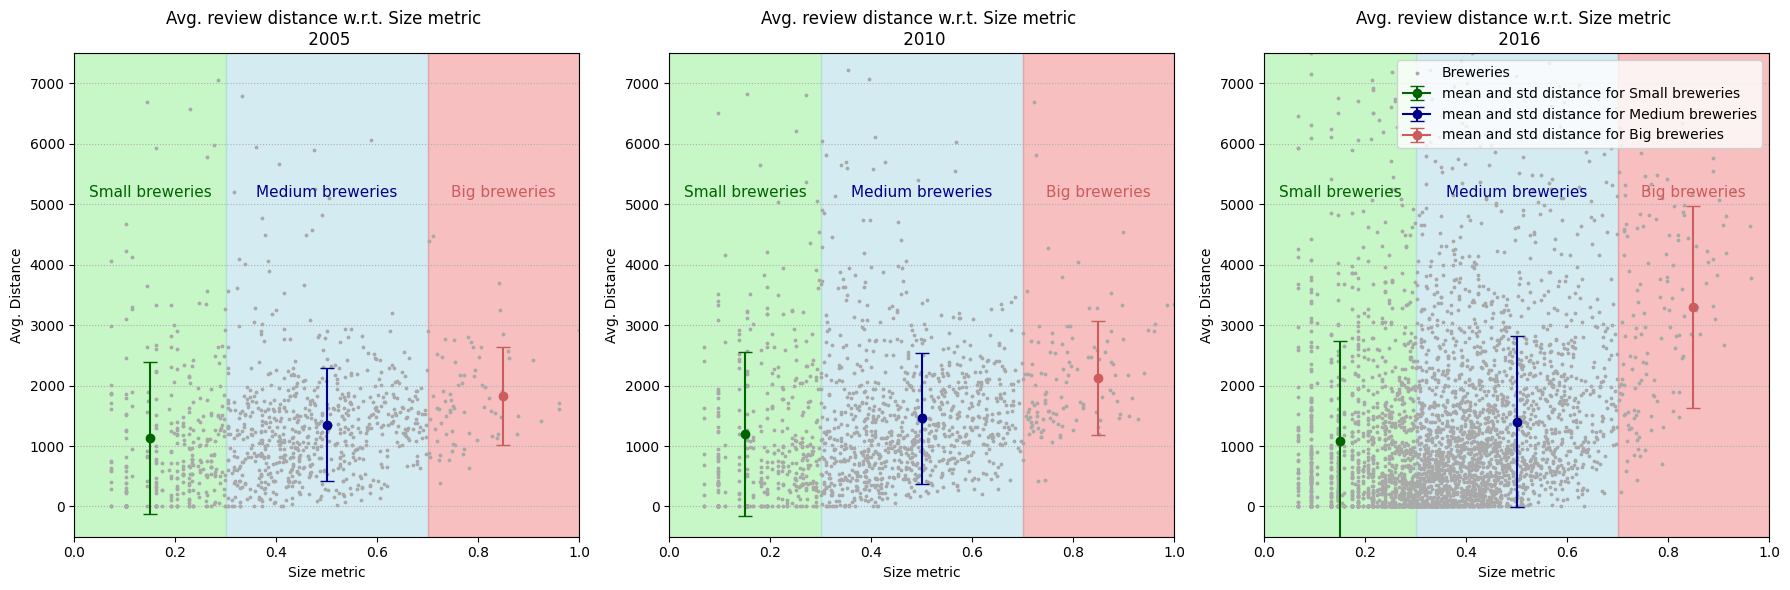

In [63]:
# List of labels, colors, and size categories
labels = ['Small', 'Medium', 'Big']
colors = ['lightgreen', 'lightblue', 'lightcoral']
dark_colors = ['darkgreen', 'darkblue', 'indianred']
size = [0, 0.3, 0.7, 1.0]
mid = [0.15, 0.5, 0.85]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
labels = ['Small breweries', 'Medium breweries', 'Big breweries']
text_positions = zip(mid, [5200, 5200, 5200], labels, dark_colors)

# Loop through dataframes and create plots
for j, df in enumerate(dfs):
    # Create lists for means and standard deviations
    means, std_devs = helpfn.compute_stats_for_categories(df, 'distance_state')

    for i in range(len(size) - 1):
        axs[j].axvspan(size[i], size[i+1], color=colors[i], alpha=0.5)
        axs[j].errorbar(mid[i], means[i], yerr=std_devs[i], fmt='o-', color=dark_colors[i],
                        ecolor=dark_colors[i], label='mean and std distance for ' + labels[i], capsize=5, alpha=1.0)
        for p, pos in enumerate(text_positions):
            axs[j].text(pos[0], pos[1], pos[2], color=pos[3], ha='center', va='center', fontsize=11)

    axs[j].scatter(df['size_metrics'], df['distance_state'], color='darkgray', label='Breweries', s=3)
    text_positions = zip(mid, [5200, 5200, 5200], labels, dark_colors)
    axs[j].set_title(f'Avg. review distance w.r.t. Size metric \n {years[j]}')
    axs[j].set_xlabel('Size metric')
    axs[j].set_ylabel('Avg. Distance')
    axs[j].set_xlim([0, 1])
    axs[j].set_ylim([-500, 7500])
    axs[j].grid(True, axis='y', linestyle=':')

# Add legend to the last subplot
axs[2].legend(loc='upper right')
plt.tight_layout()
plt.show()


## Conclusion
We can conclude that both analysis give very similar results, which validate the approach.